In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

from pyspark.sql import SparkSession
import axs

import pyspark.sql.functions as sparkfunc
from functools import partial
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col
from pyspark.sql.functions import size

from fit import preprocess, fit_band, plot_model

In [2]:
spark = ( 
    SparkSession
    .builder
    .config("spark.master", "local[*]")
    .config("spark.driver.memory", "120g")
    .config("spark.driver.maxResultSize", "0")
    .enableHiveSupport()
    .getOrCreate()
)

In [3]:
import socket
port = spark.sparkContext.uiWebUrl.split(":")[-1]
hostname = socket.gethostname()
print(f"https://{hostname}/jupyter/user/stevengs/proxy/{port}/jobs/")

https://epyc.astro.washington.edu/jupyter/user/stevengs/proxy/4046/jobs/


In [4]:
catalog = axs.AxsCatalog(spark)

In [5]:
band = "r"
fit_catalog_name = f"stevengs_cut_wtf_fits_{band}_band"
df = catalog.load(fit_catalog_name)

In [6]:
# create a column with absolute values of skew
_df = df.withColumn(
    "skew_abs", 
    udf(lambda row : abs(row['params']['skew']), FloatType())(df['fit_r'])
)
# sort the data by dip significance
_df = _df.sort(
    _df['dip']['significance'],
    ascending=False
)

Create $\chi^2$ distribution

In [7]:
chi_sq = _df.select(_df['fit_r']['chi_square_reduced']).collect()

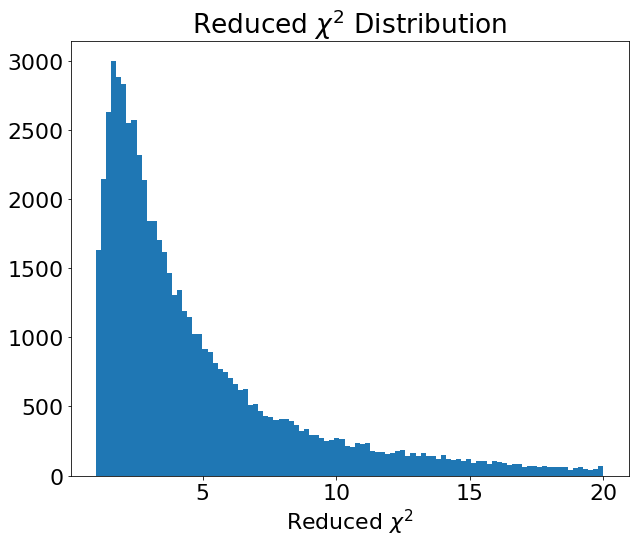

In [8]:
plt.rc("figure", figsize=[10, 8])
plt.rc("font", size=22)
plt.hist([_['fit_r.chi_square_reduced'] for _ in chi_sq], bins=100, range=(1, 20))
plt.title("Reduced $\chi^2$ Distribution")
plt.xlabel("Reduced $\chi^2$")
plt.show()

Create skew parameter distribution

In [9]:
skew = _df.select(_df['fit_r']['params']['skew']).collect()

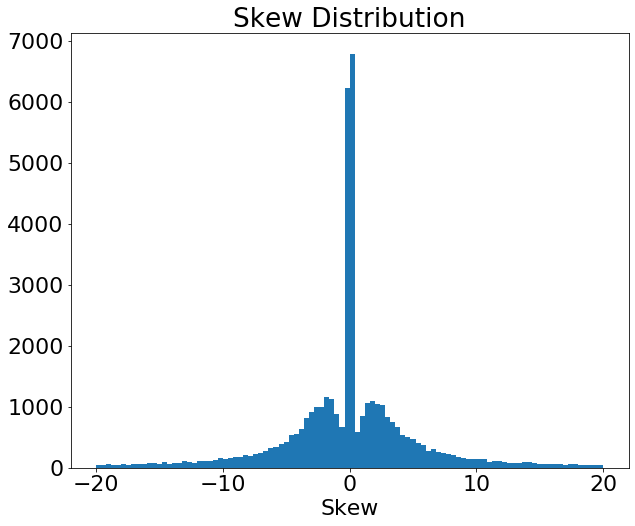

In [10]:
plt.hist([_['fit_r.params.skew'] for _ in skew], bins=100, range=(-20, 20))
plt.title("Skew Distribution")
plt.xlabel("Skew")
plt.show()

Filter for good fits

In [11]:
fits_to_show = _df.where(
    (_df['fit_r.chi_square_reduced'] < 5) &  
    (
        (_df['fit_r.params.skew'] > 2) | (_df['fit_r.params.skew'] < -2)
    )
)

Number of light curves that have passed the cut

In [12]:
fits_to_show.count()

28751

Plot light curves and fits. Remember, these are sorted by dip significance.

In [13]:
fits_to_show_in_memory = fits_to_show.collect()

33.28120040893555


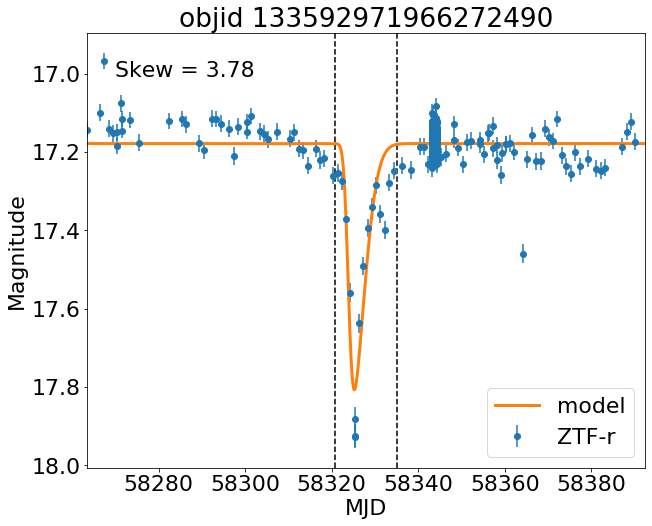

26.744962692260742


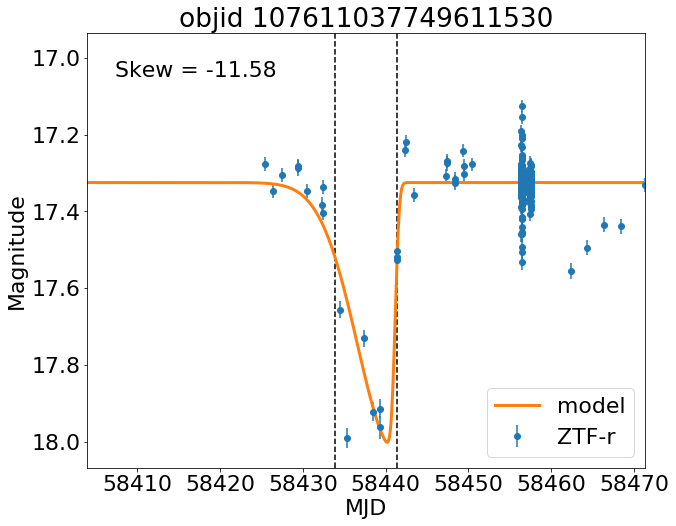

25.67387580871582


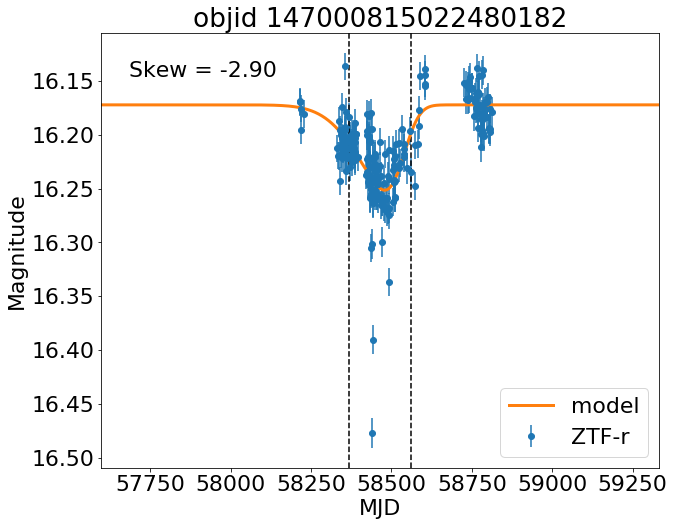

24.705665588378906


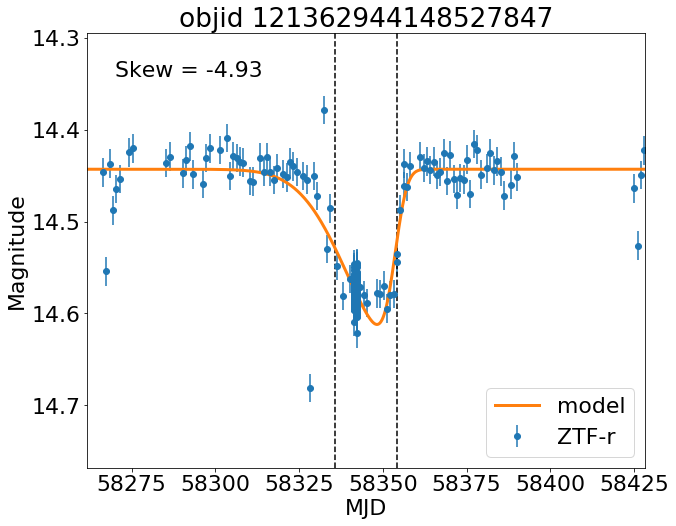

24.447803497314453


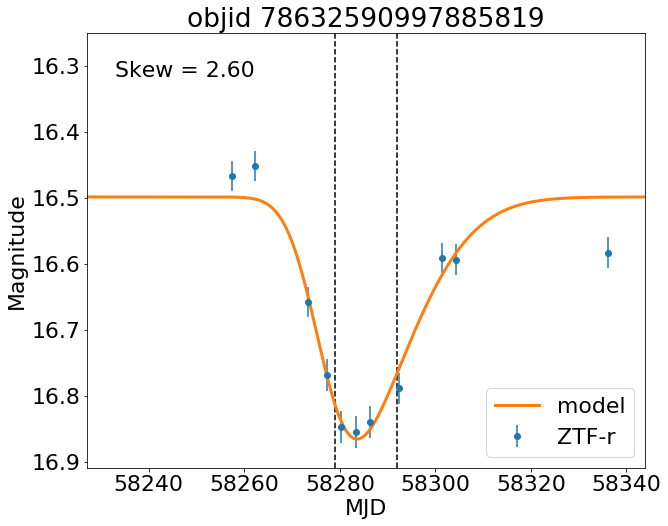

24.200231552124023


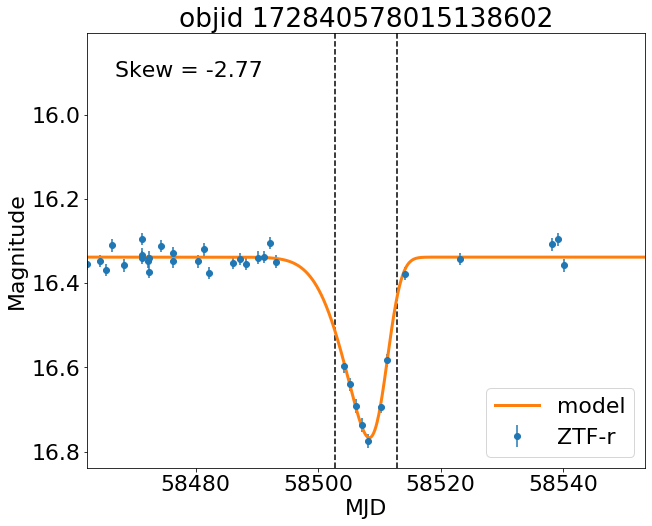

24.17249870300293


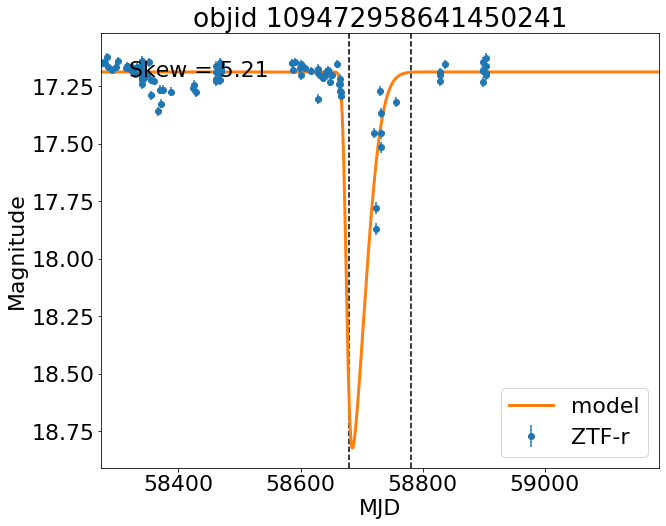

23.816293716430664


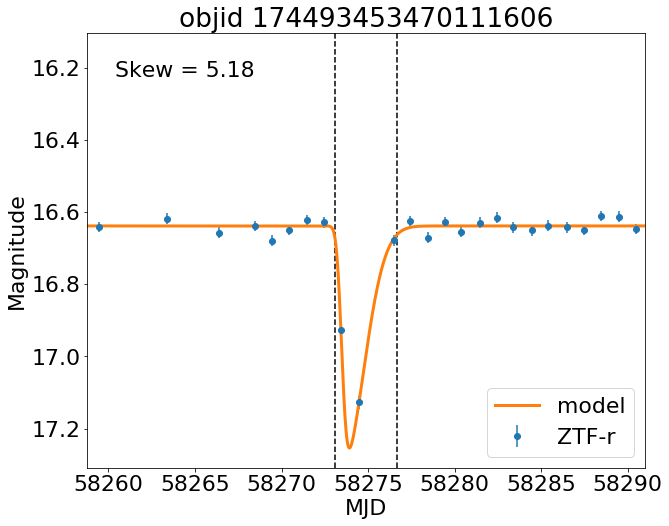

23.784608840942383


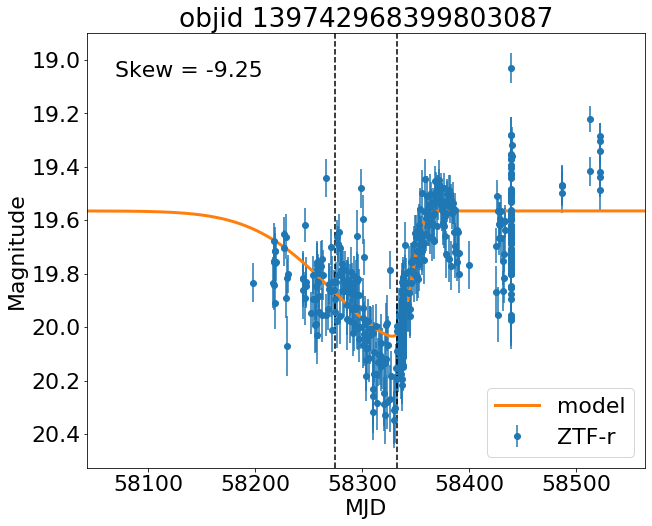

23.784608840942383


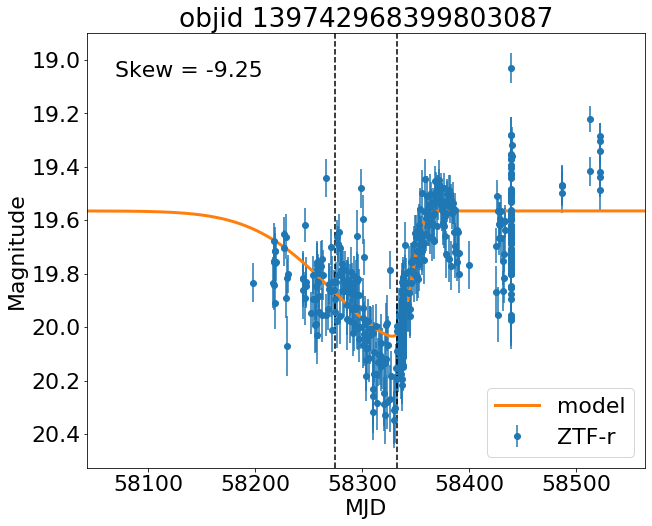

23.7554931640625


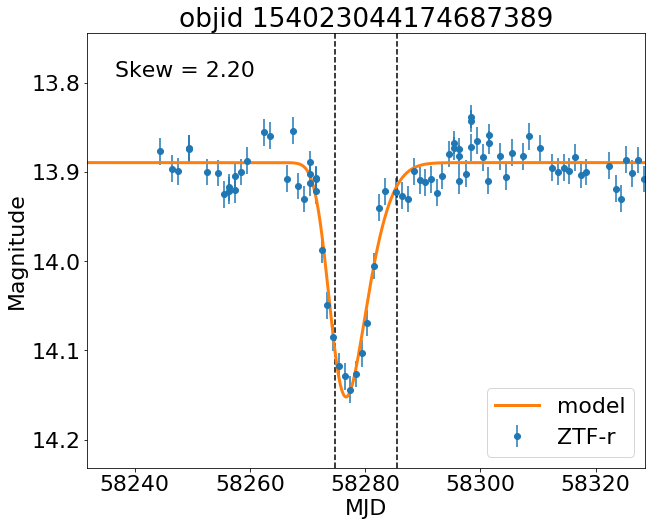

23.46469497680664


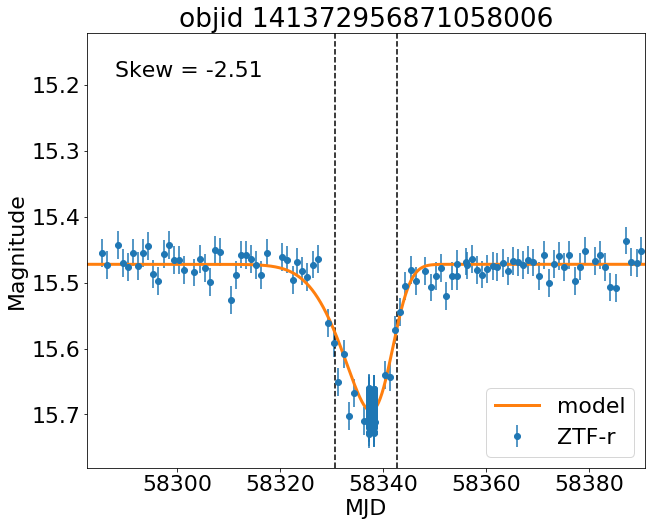

23.043537139892578


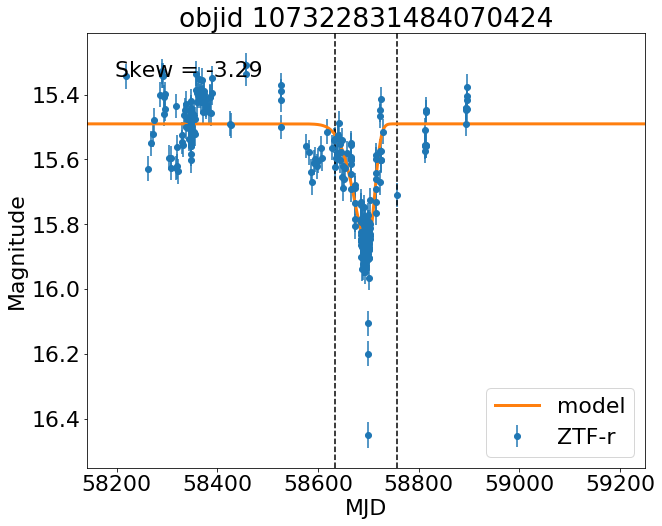

22.92140769958496


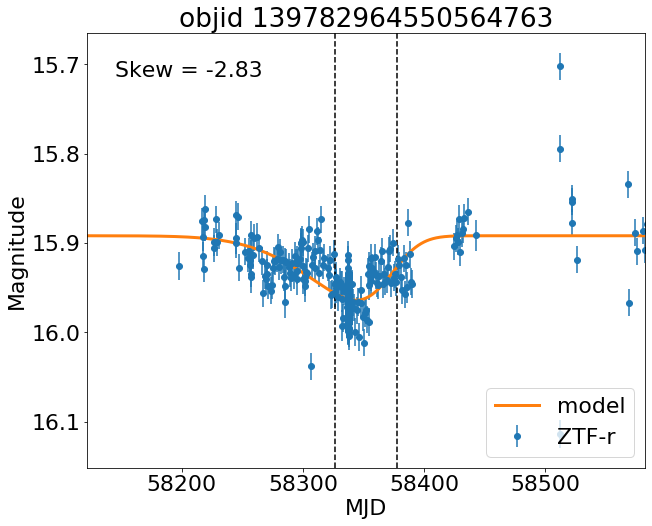

22.88143539428711


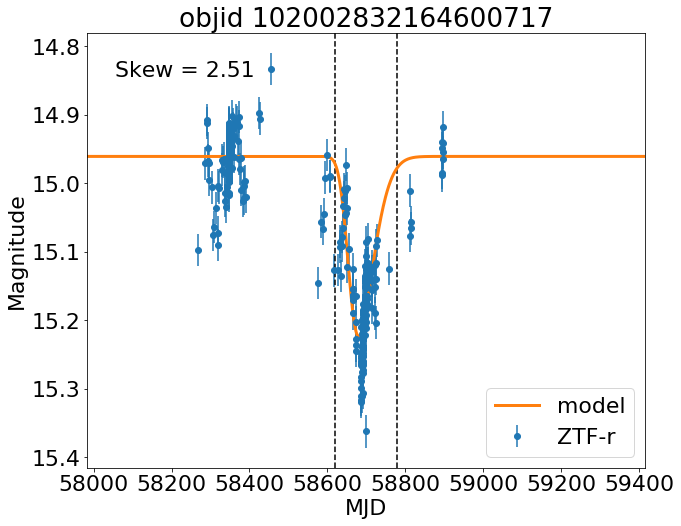

22.88143539428711


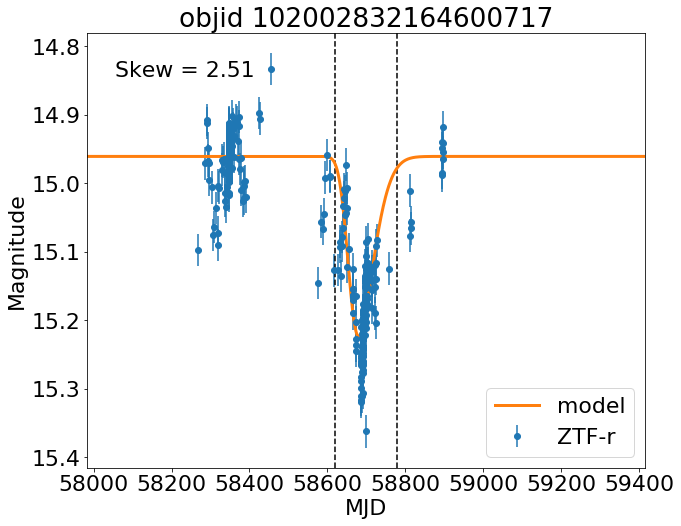

22.441946029663086


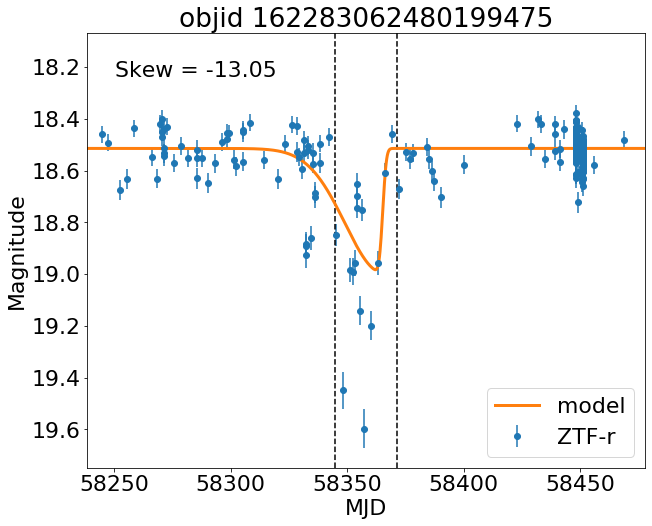

22.39006233215332


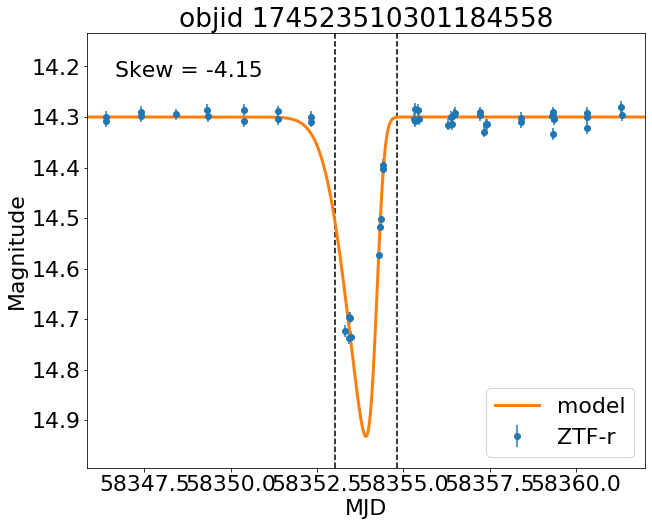

22.182559967041016


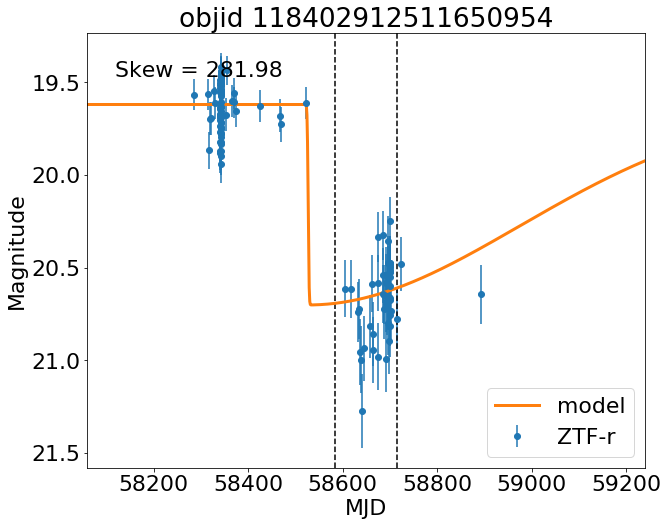

22.182559967041016


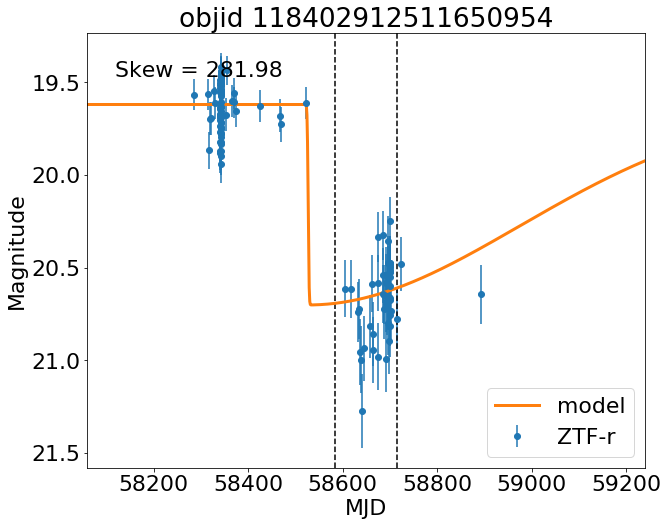

21.703048706054688


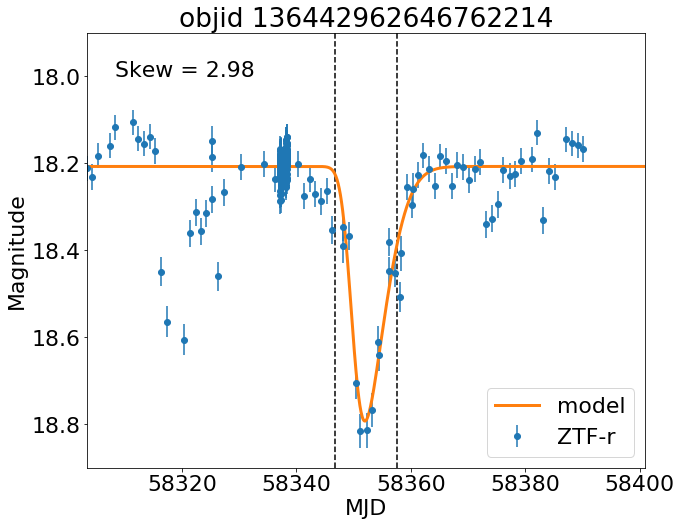

21.703048706054688


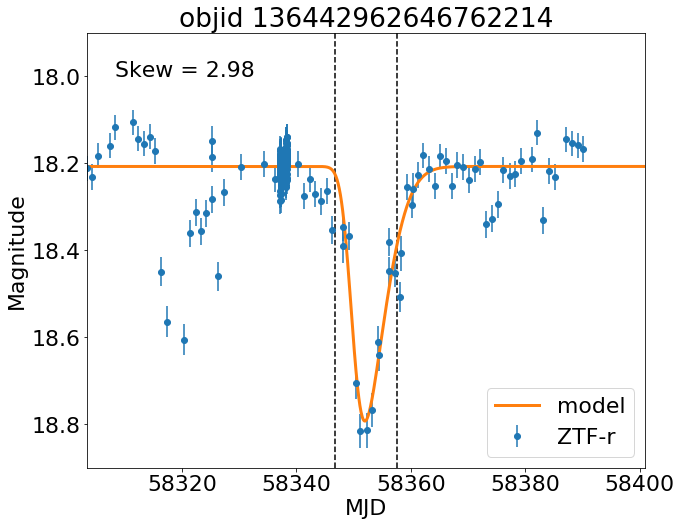

21.34234046936035


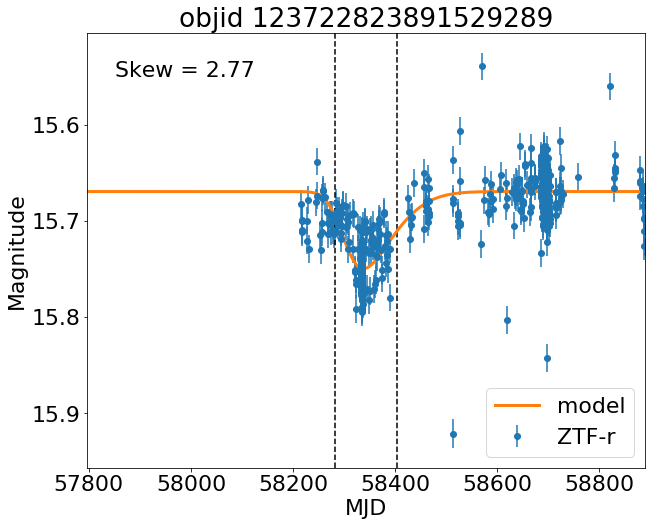

21.121496200561523


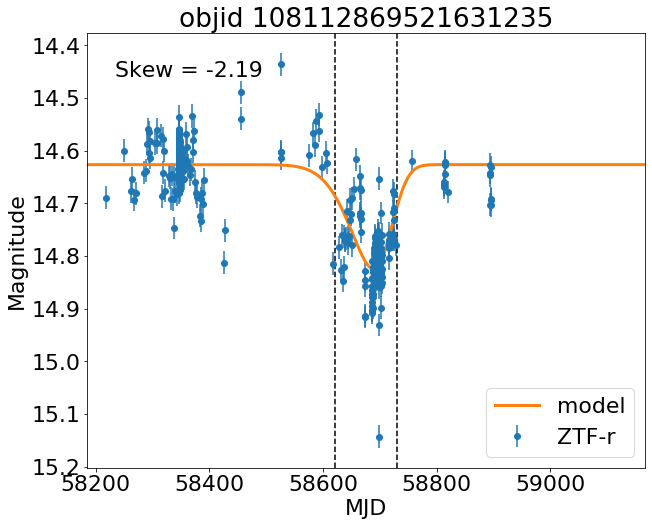

20.994558334350586


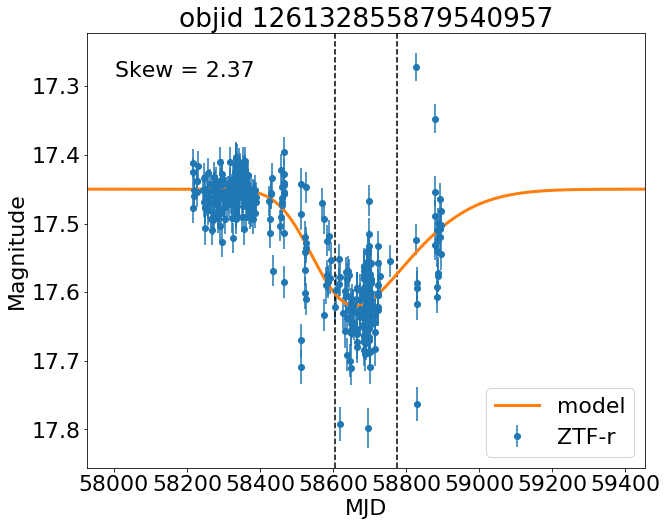

20.862224578857422


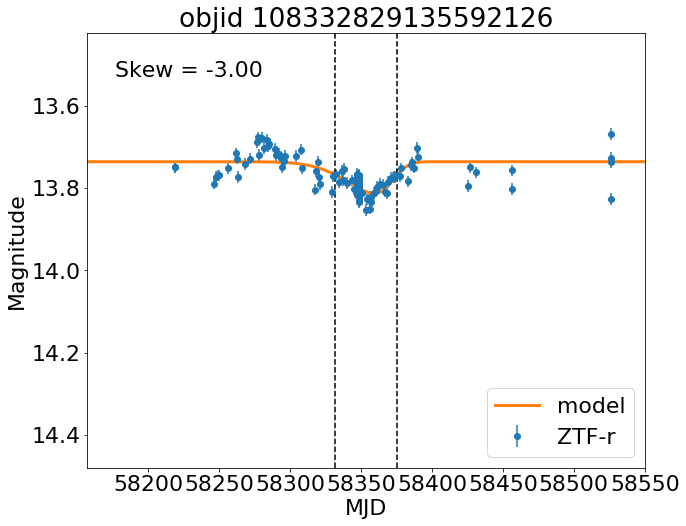

20.30562973022461


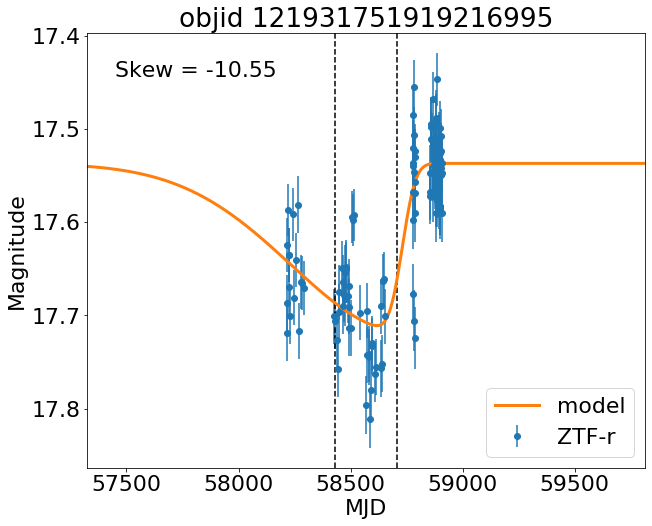

20.292137145996094


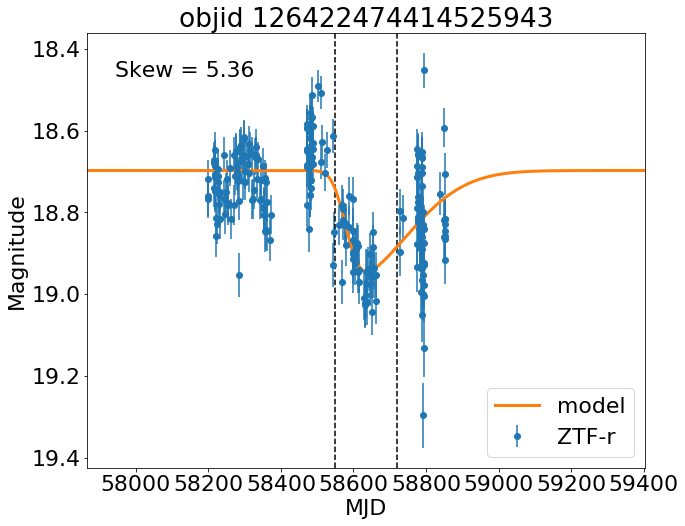

20.04683494567871


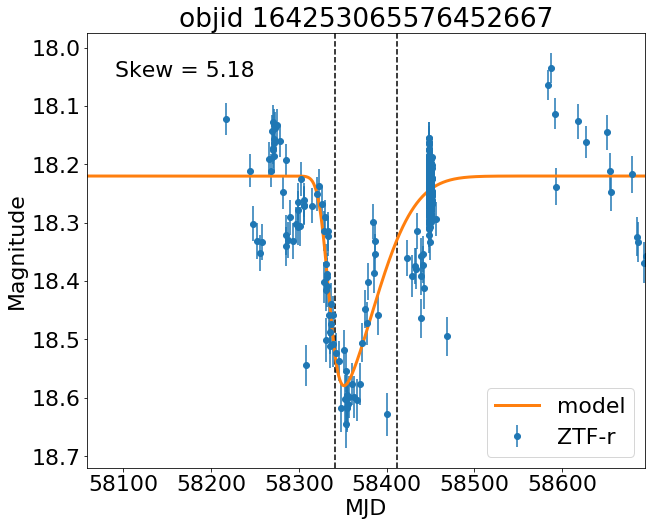

19.962244033813477


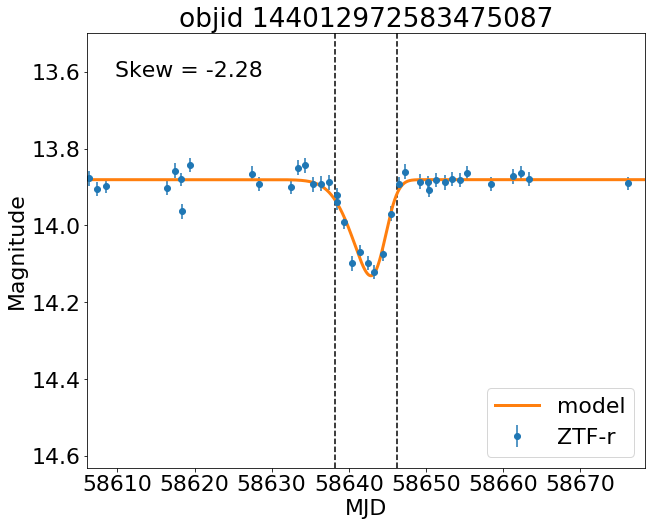

19.682710647583008


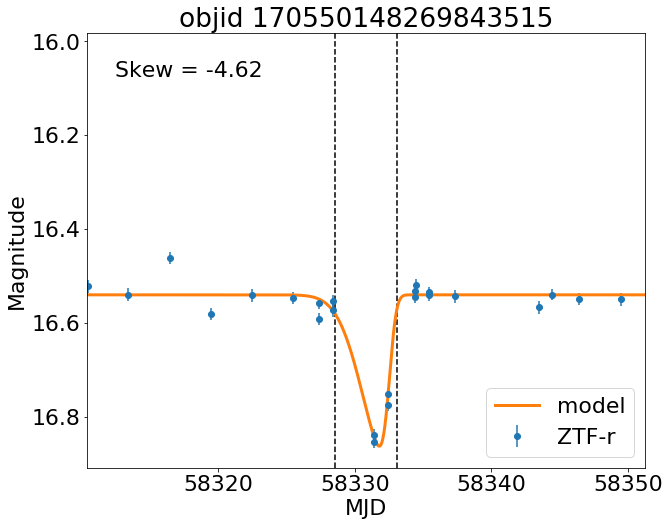

19.43265724182129


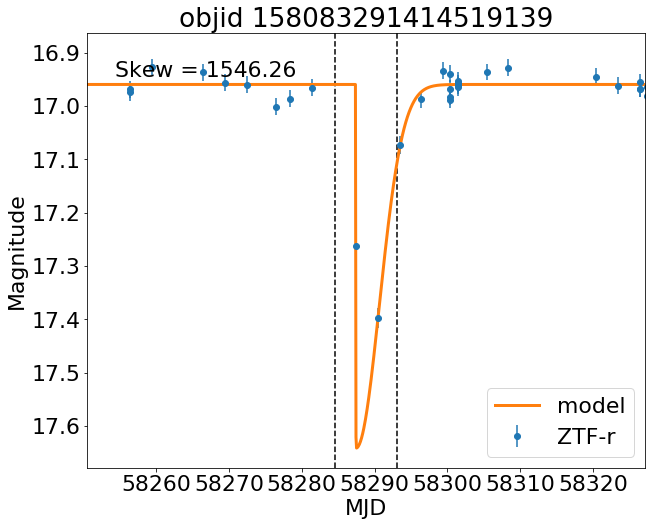

19.340959548950195


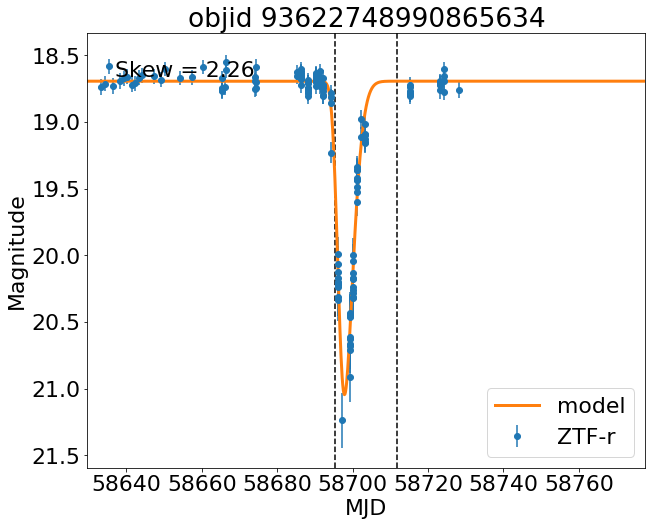

19.282289505004883


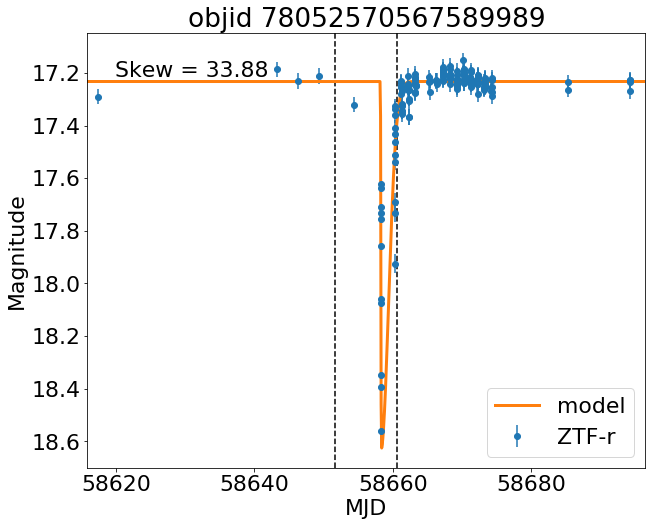

19.190475463867188


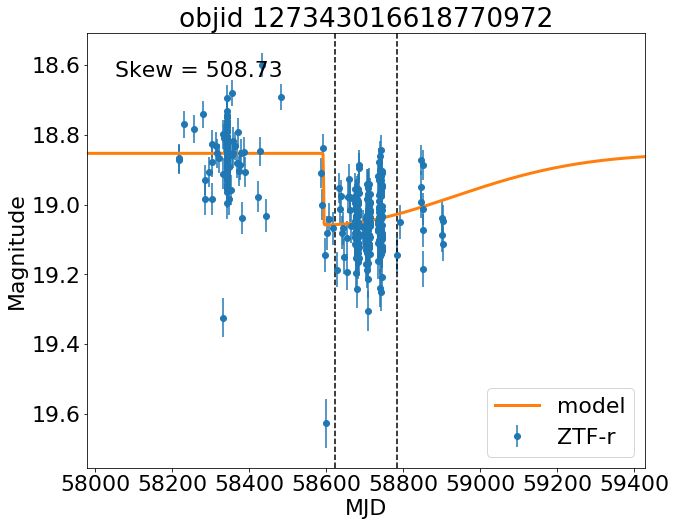

19.190475463867188


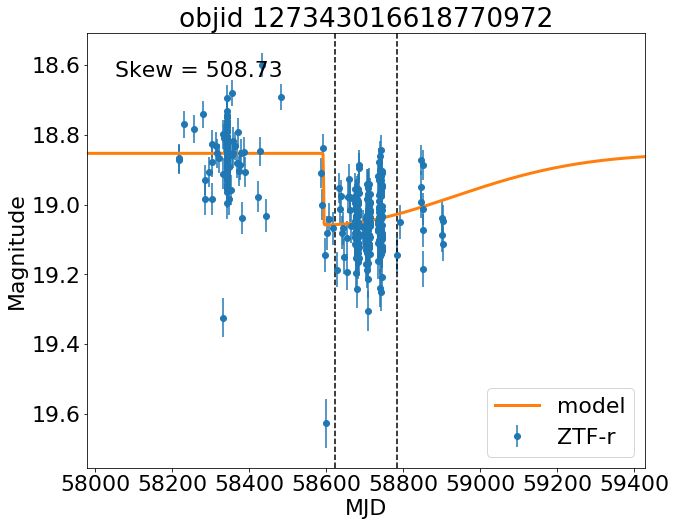

18.708332061767578


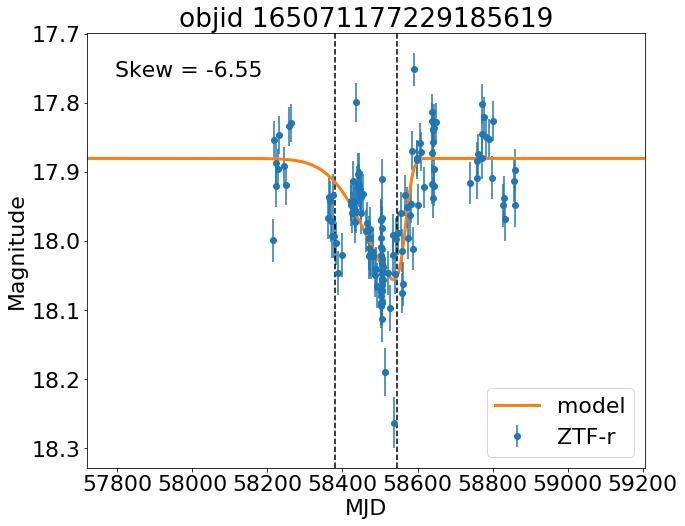

18.61186981201172


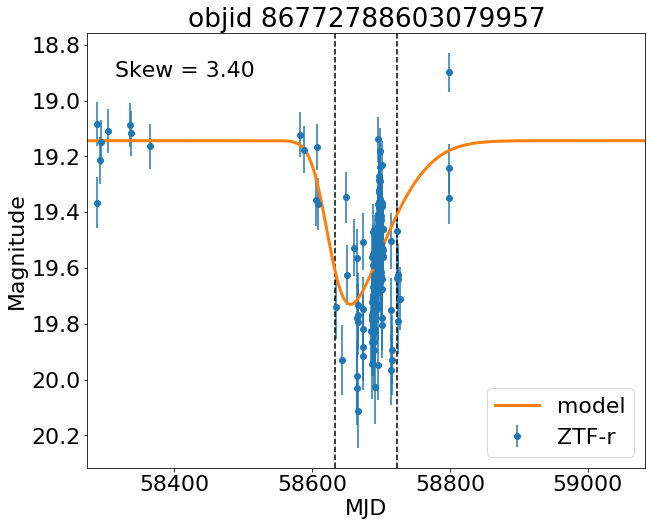

18.58343505859375


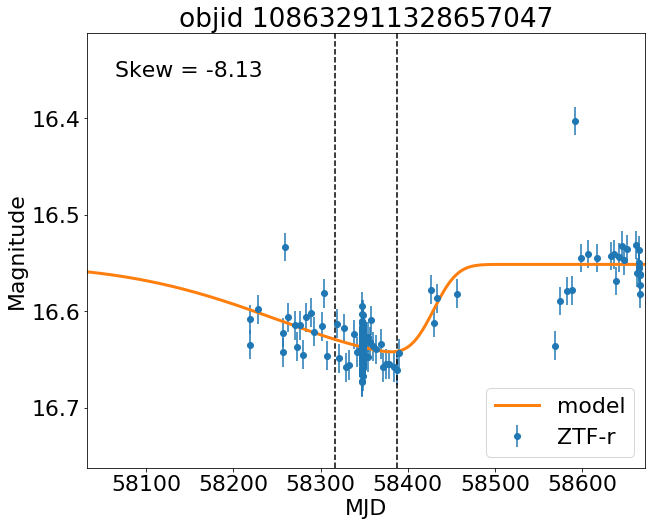

18.57744598388672


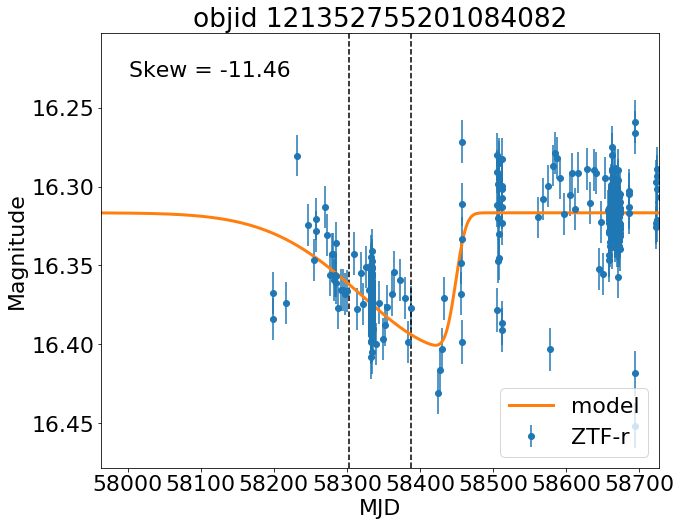

18.418556213378906


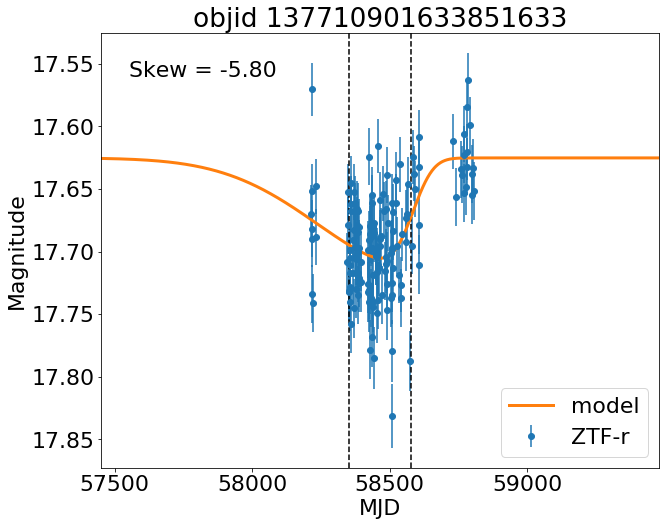

18.390897750854492


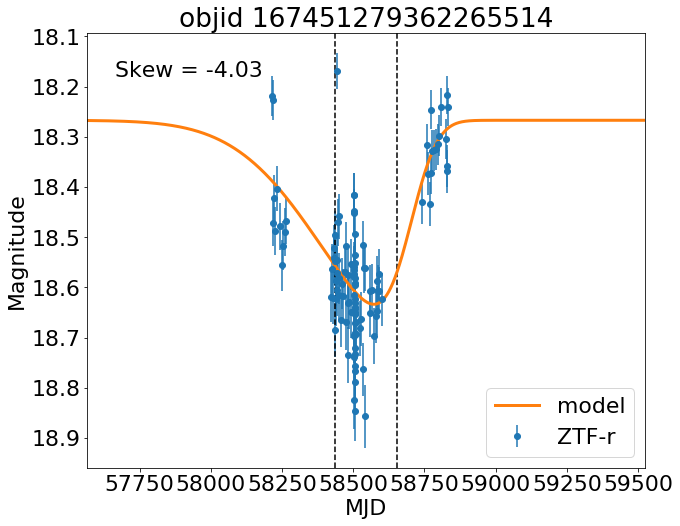

18.322961807250977


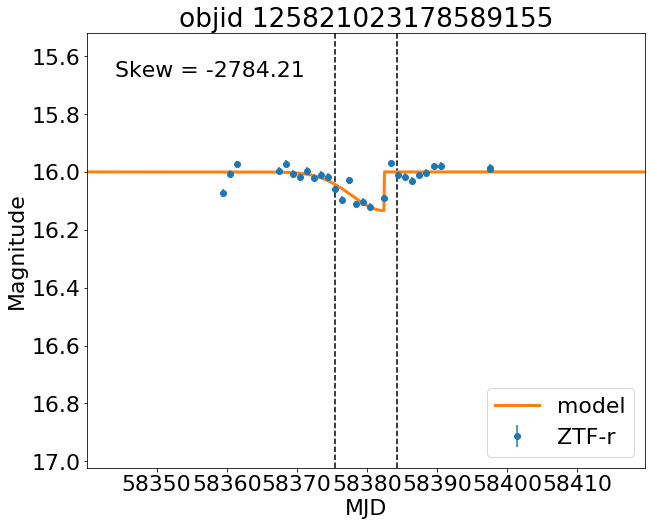

18.079801559448242


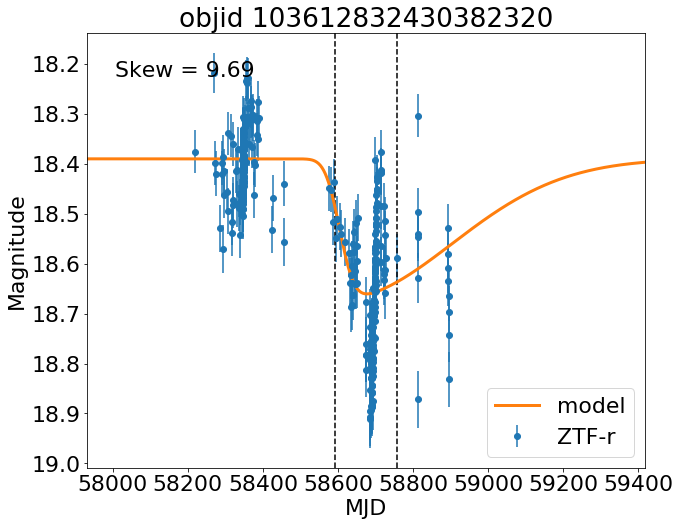

18.014925003051758


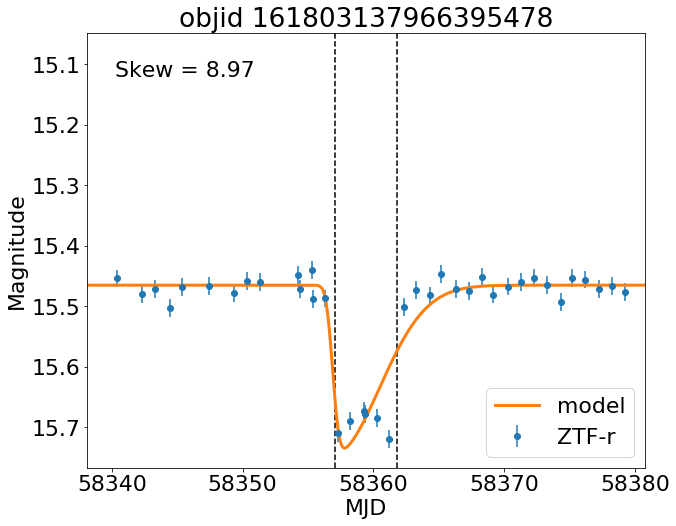

18.00975799560547


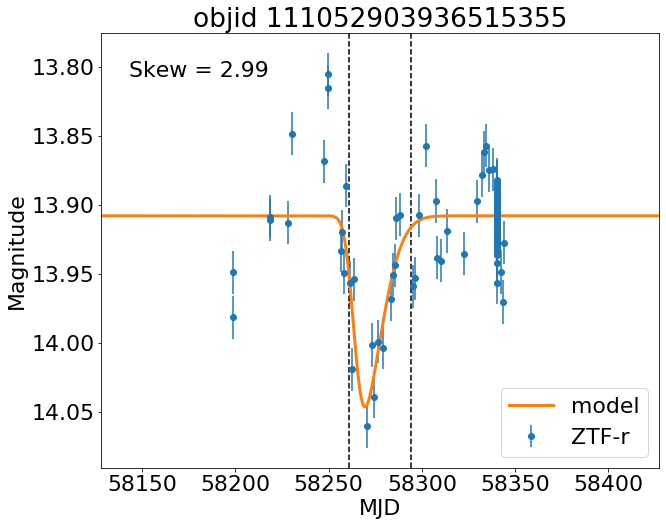

17.910097122192383


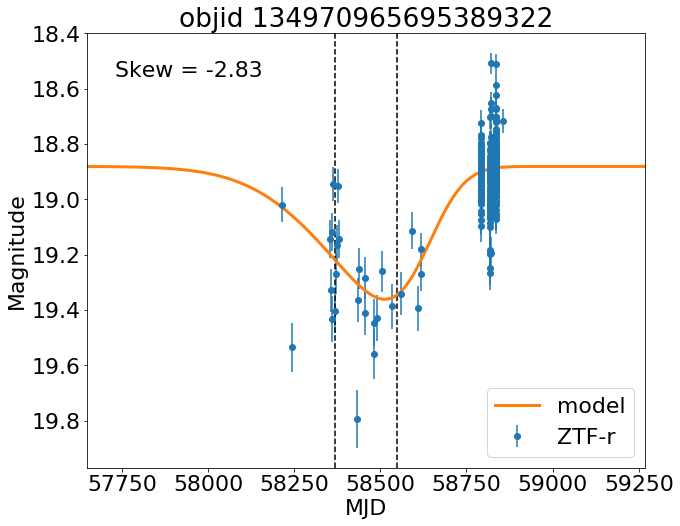

17.787141799926758


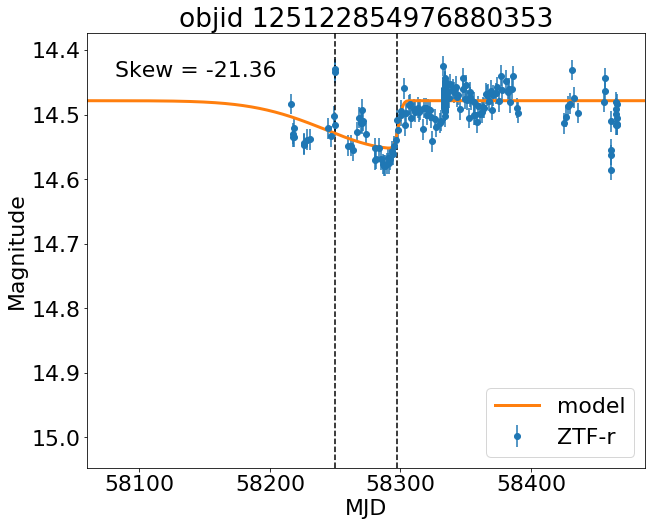

17.78385353088379


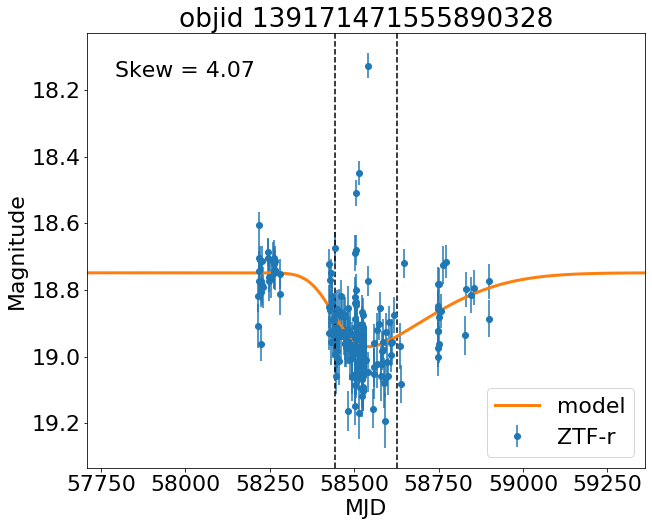

17.726512908935547


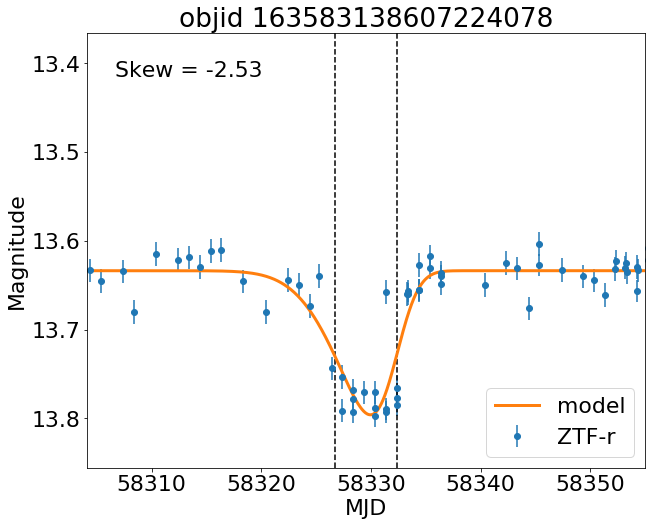

17.62985610961914


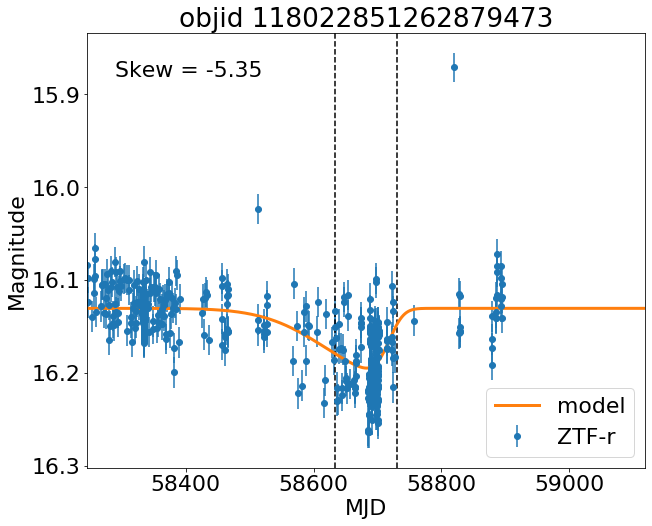

17.590944290161133


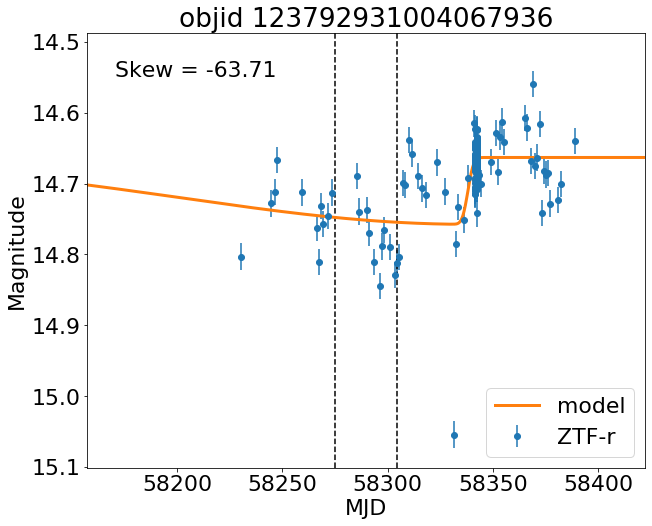

17.554399490356445


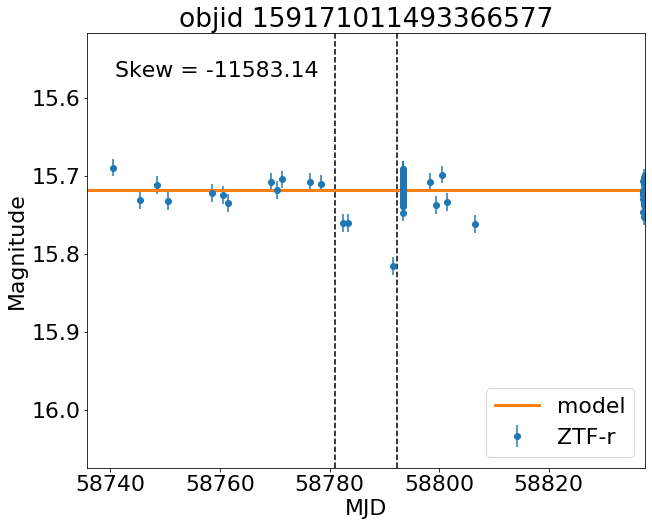

17.49786949157715


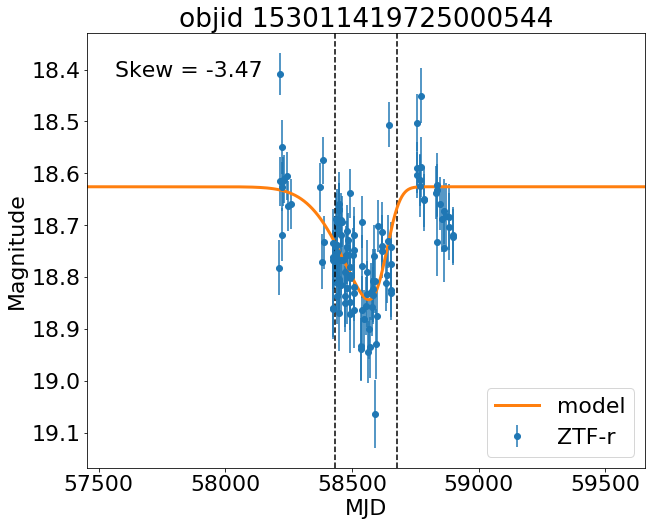

17.497100830078125


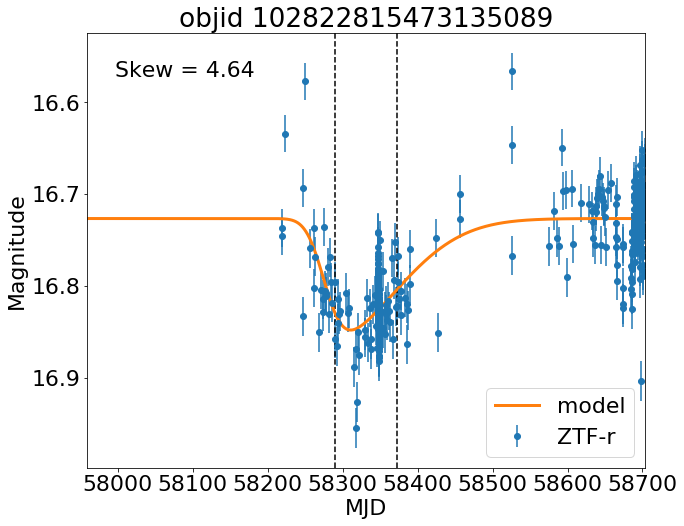

17.438514709472656


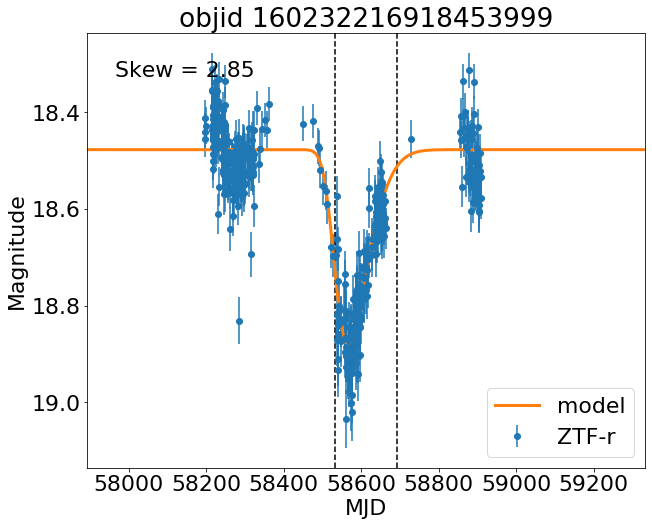

17.386470794677734


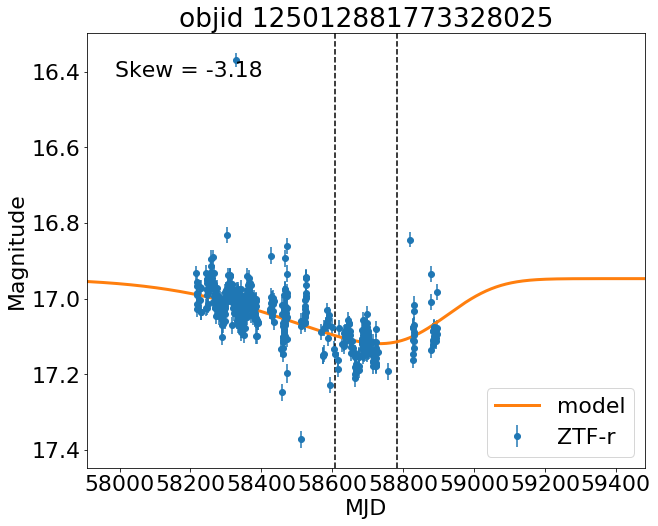

17.306621551513672


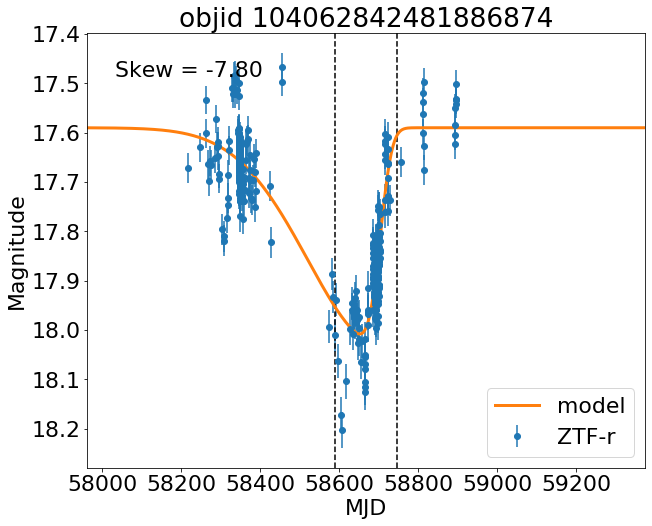

17.27921485900879


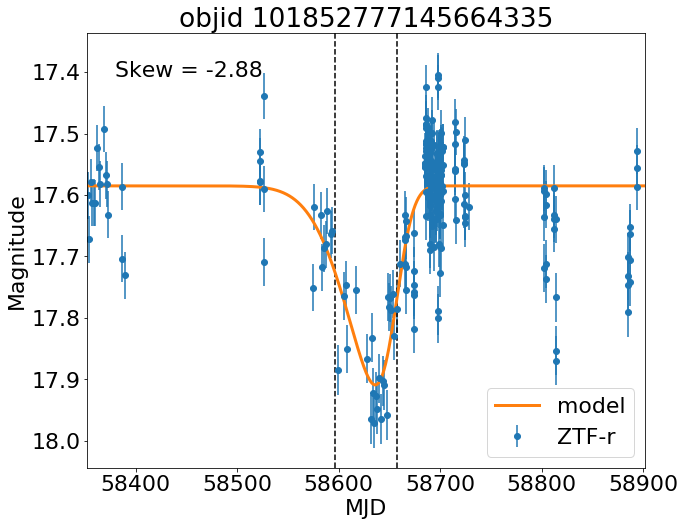

17.17770767211914


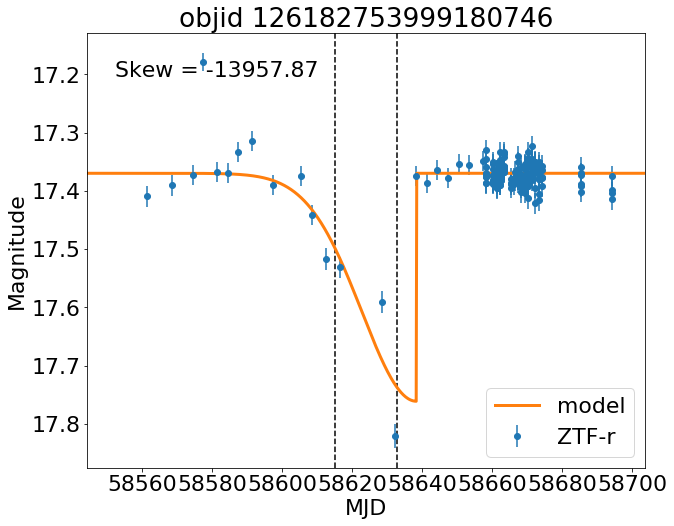

17.17770767211914


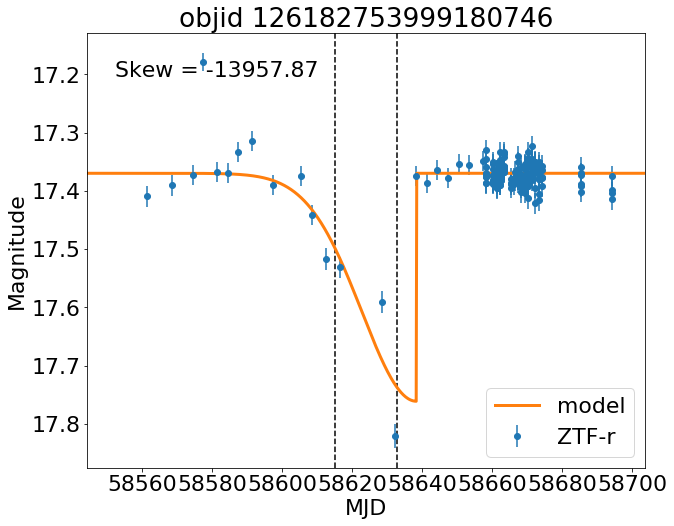

17.17356300354004


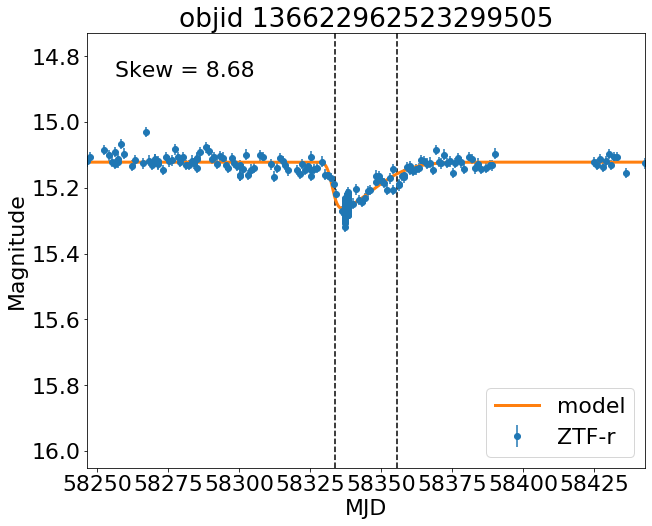

17.109140396118164


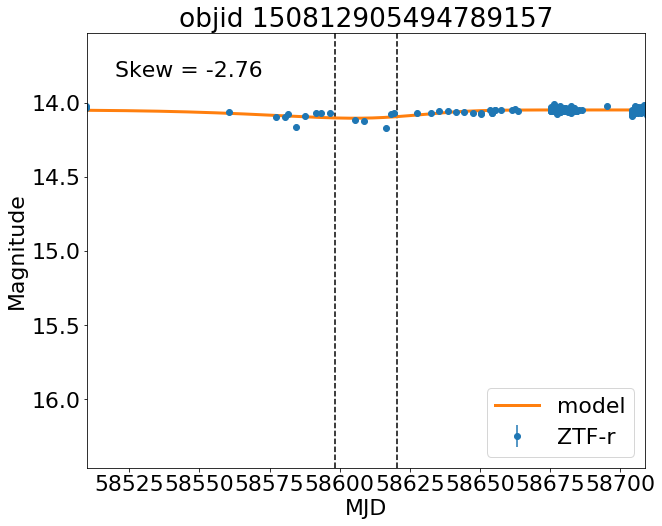

17.07964324951172


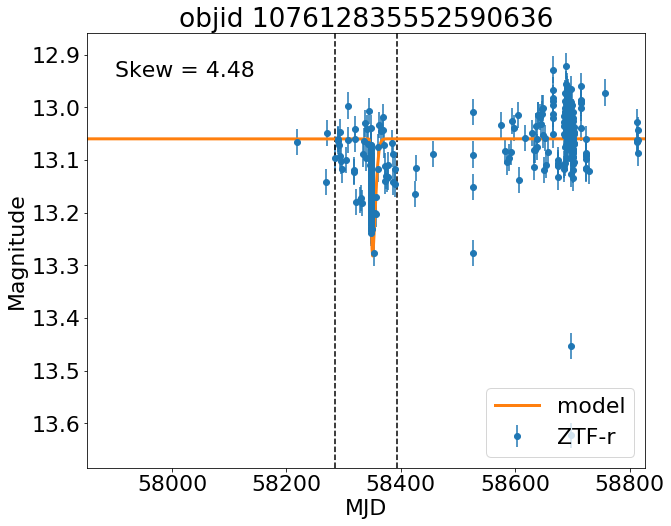

16.994104385375977


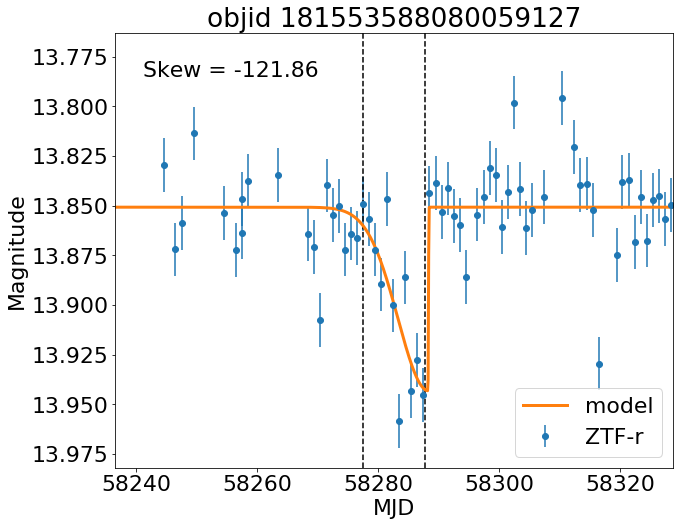

16.991493225097656


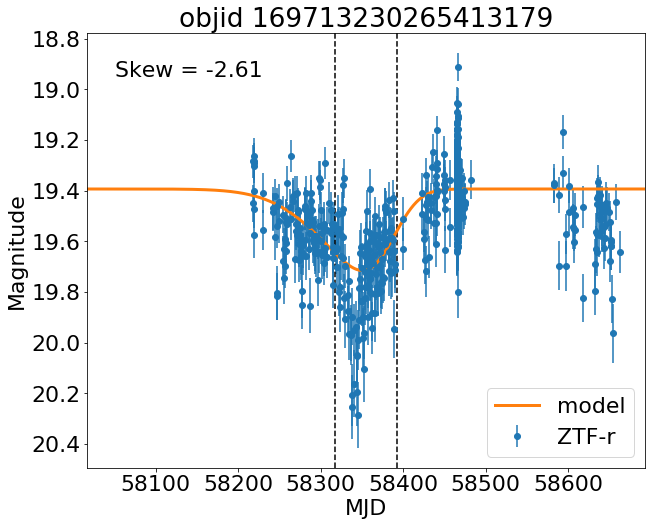

16.94841957092285


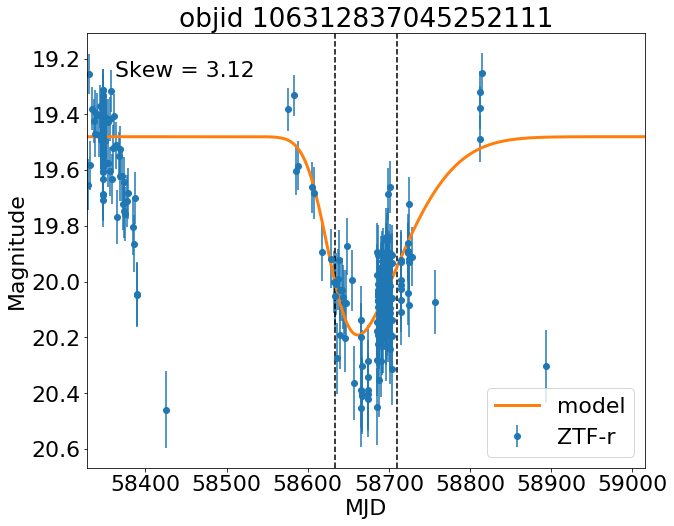

16.915674209594727


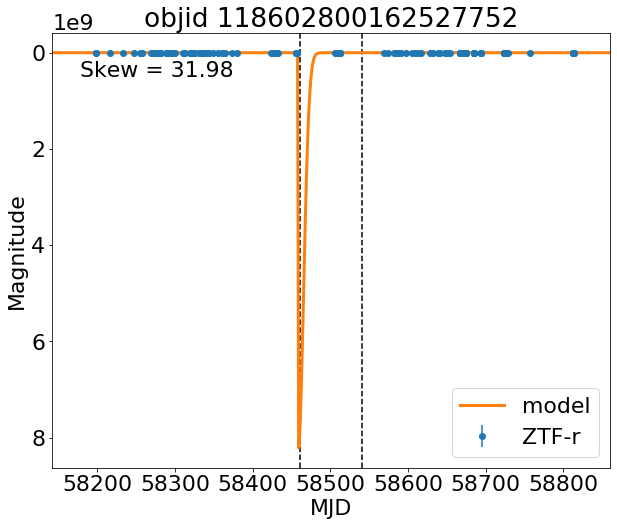

16.911653518676758


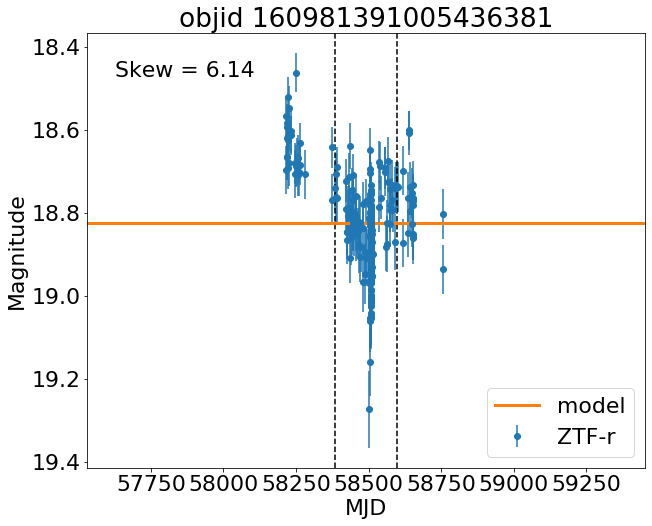

16.875385284423828


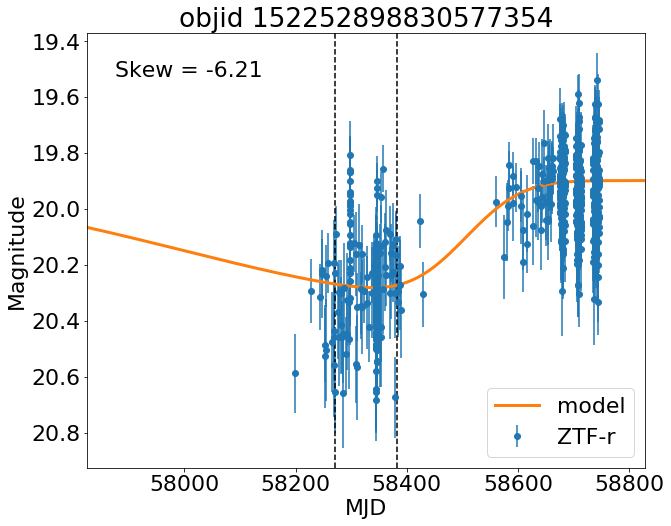

16.846038818359375


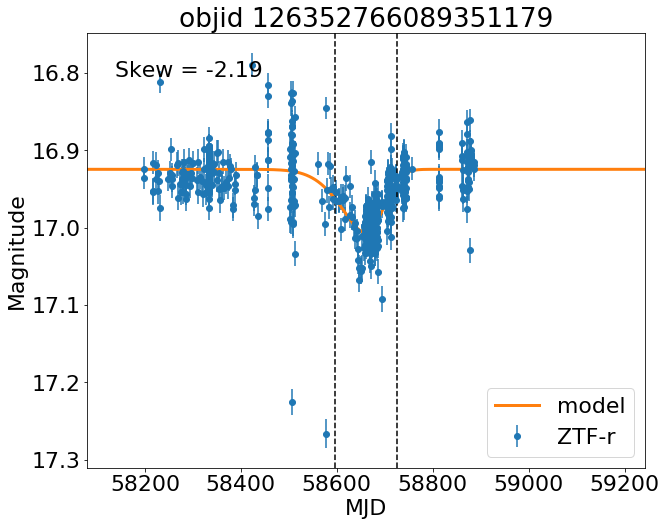

16.763519287109375


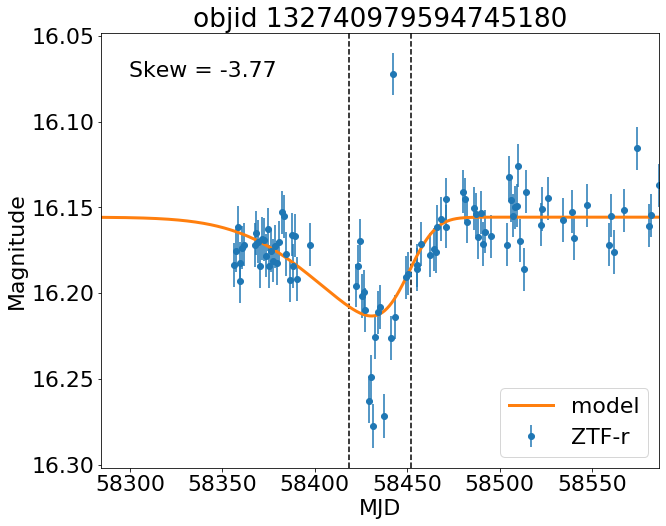

16.762435913085938


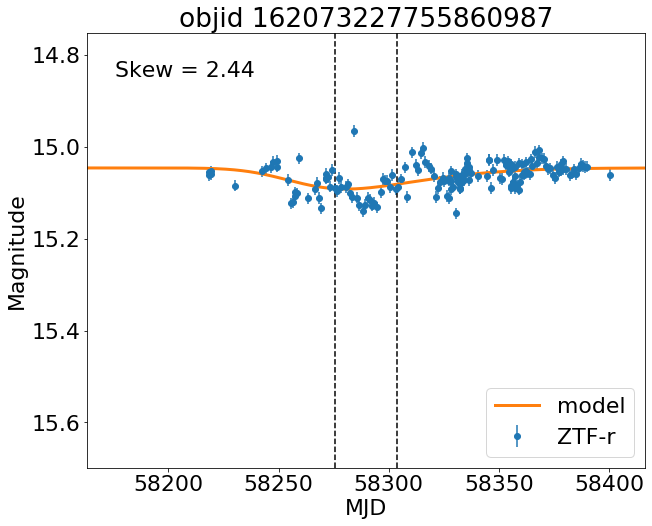

16.727859497070312


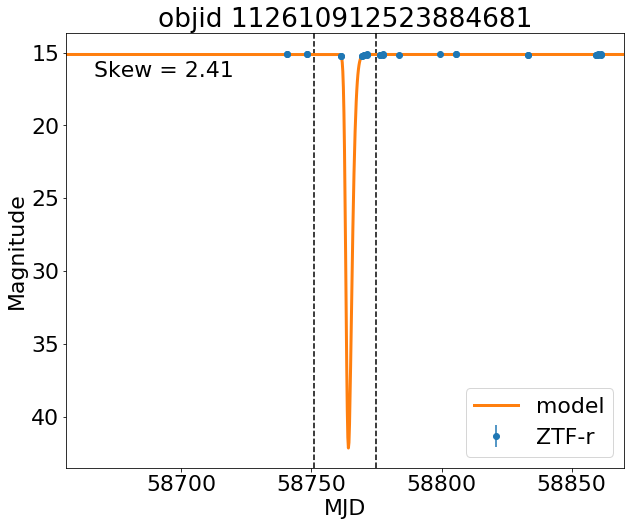

16.7262020111084


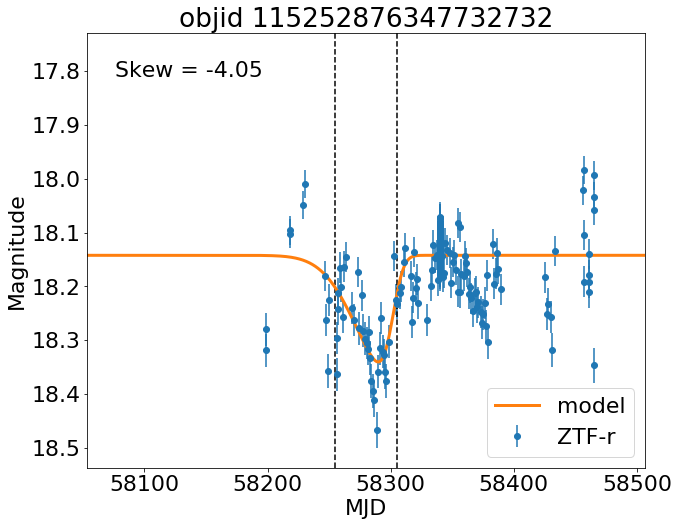

16.697607040405273


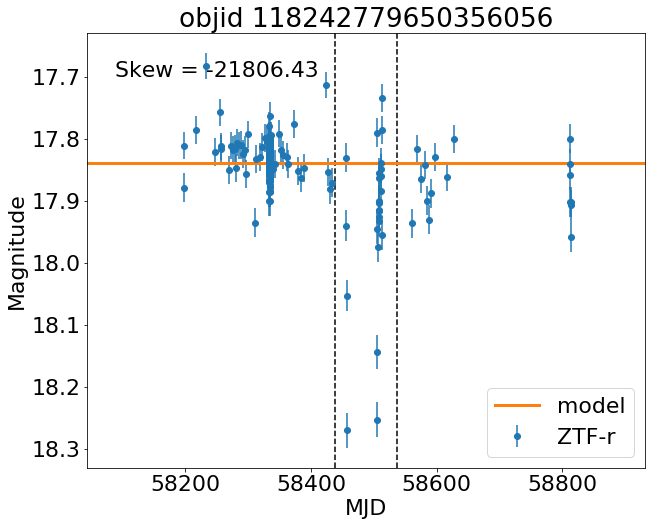

16.688283920288086


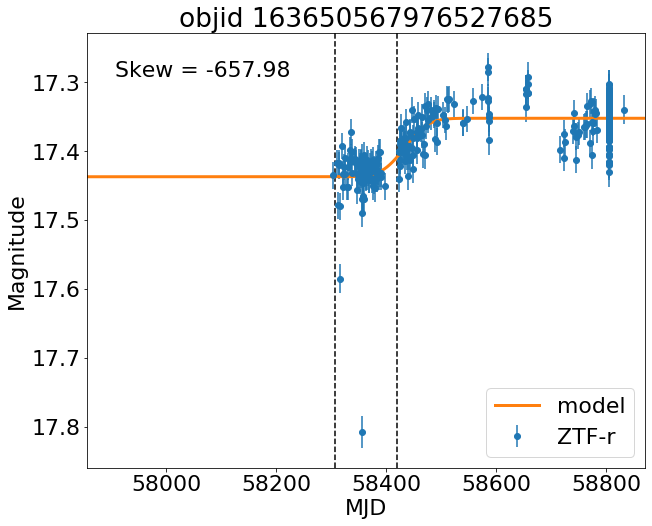

16.55994987487793


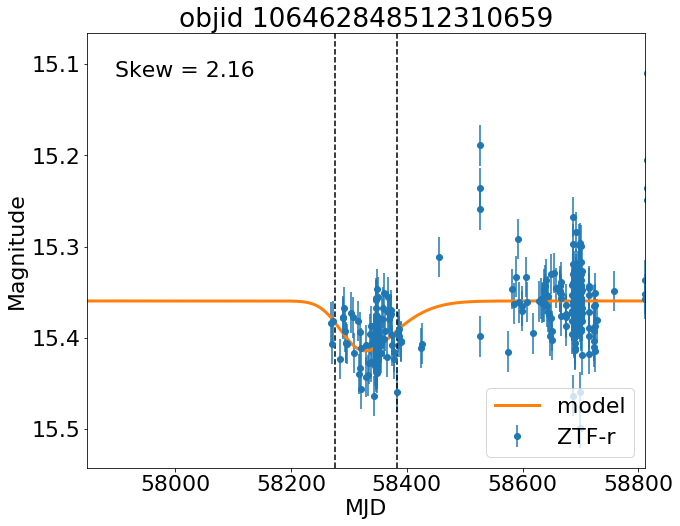

16.55994987487793


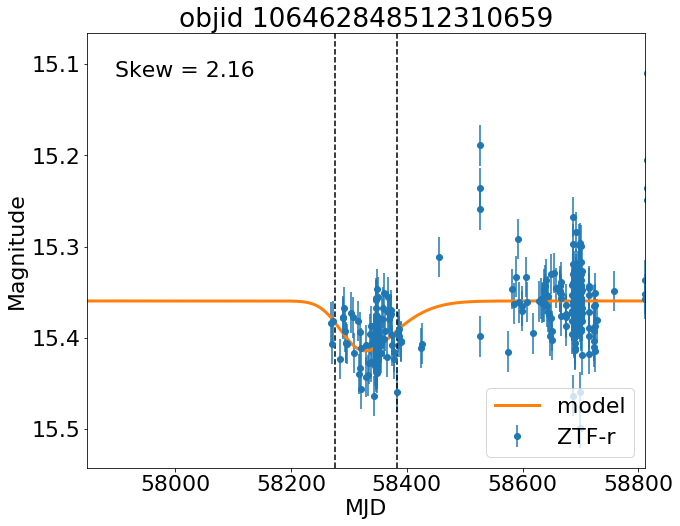

16.51377296447754


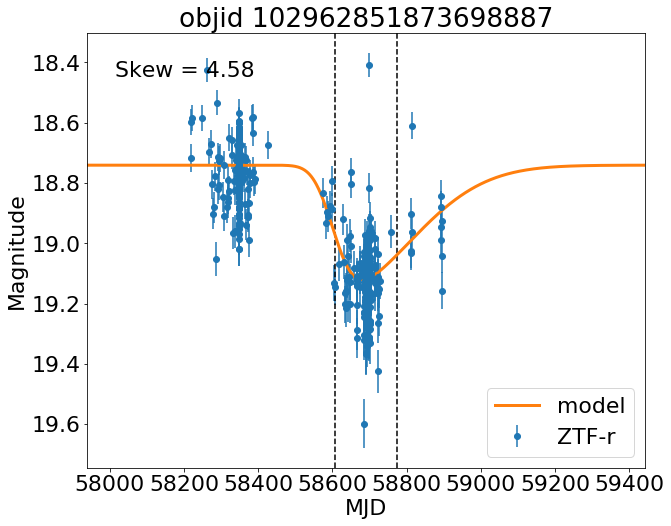

16.487966537475586


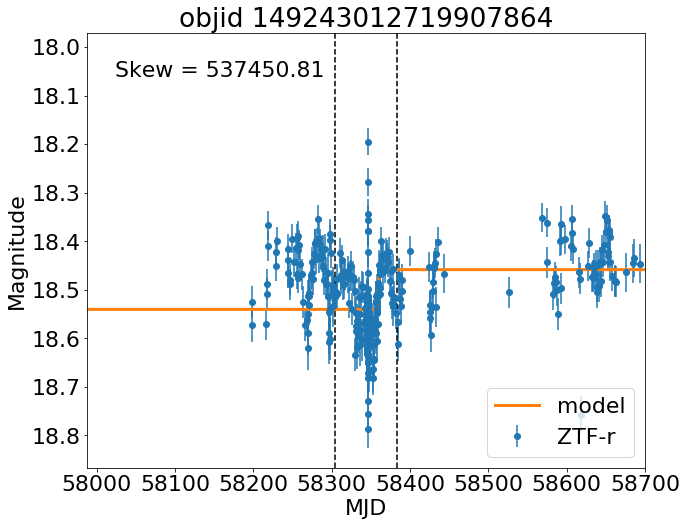

16.47737693786621


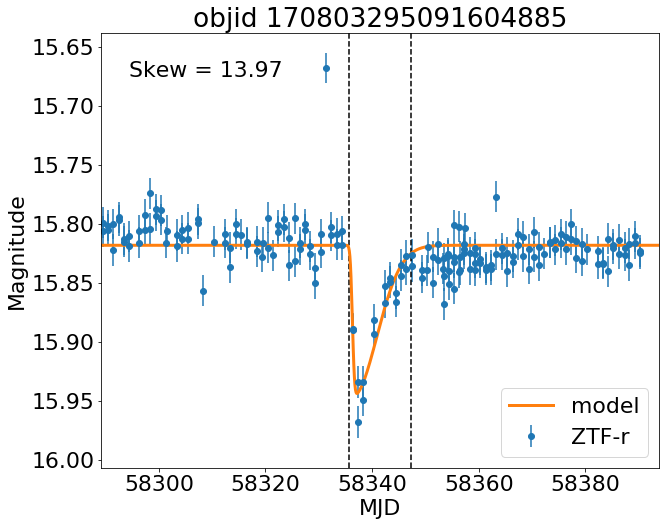

16.467891693115234


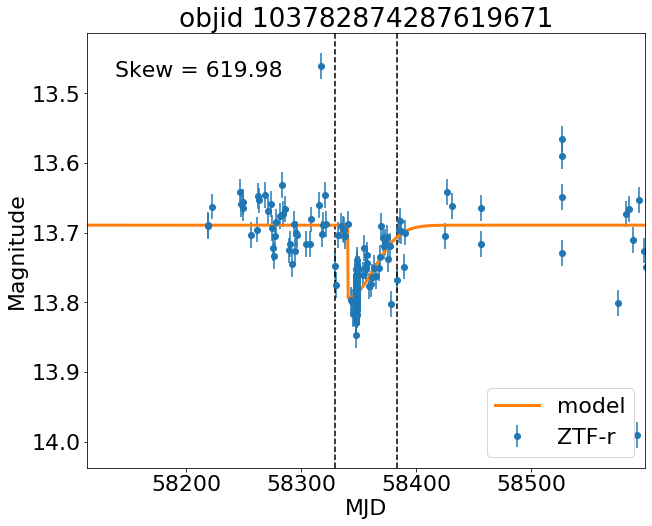

16.428600311279297


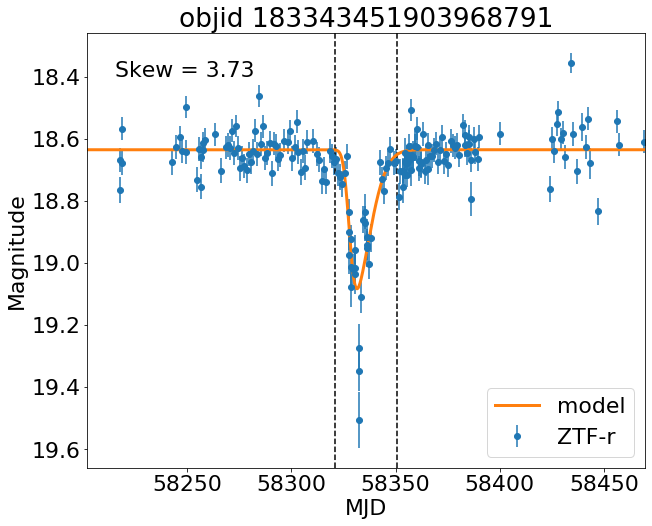

16.392078399658203


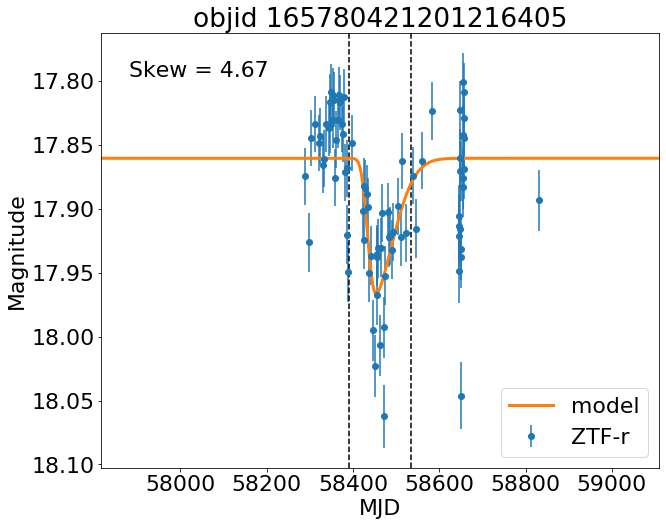

16.33369255065918


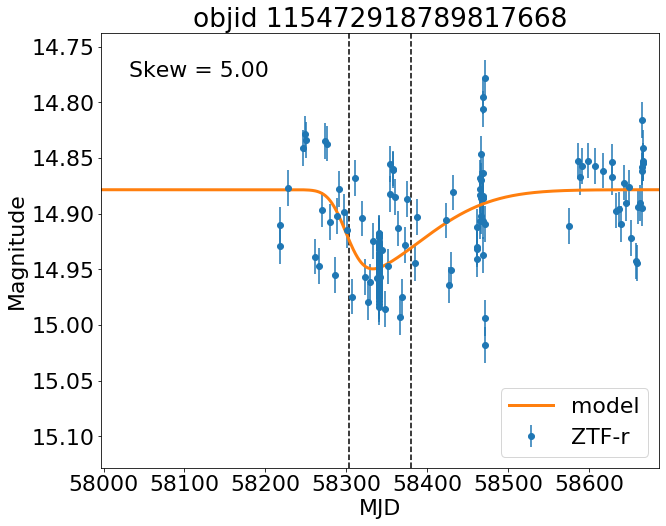

16.3292293548584


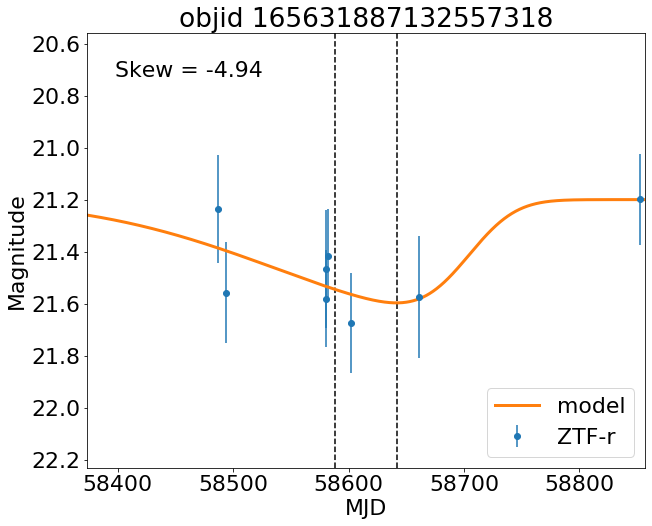

16.32341766357422


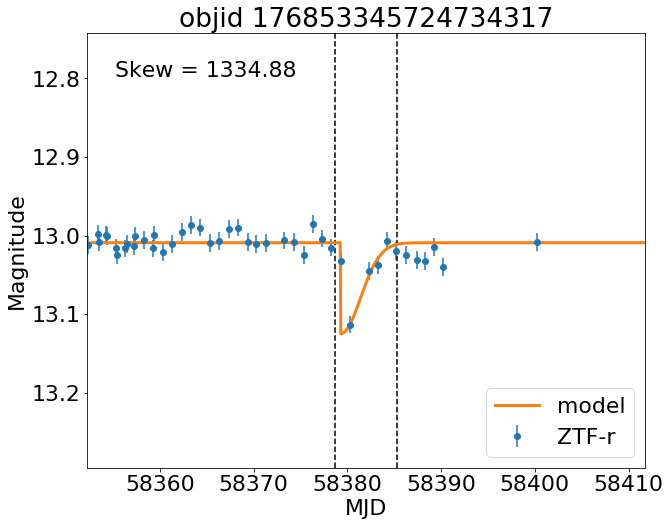

16.282888412475586


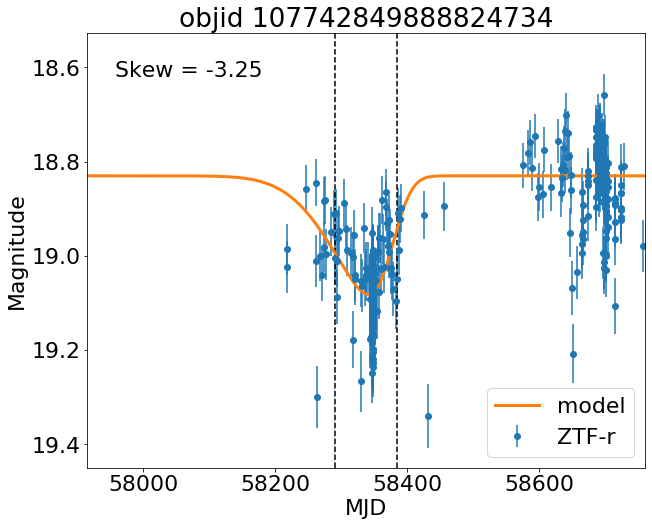

16.282888412475586


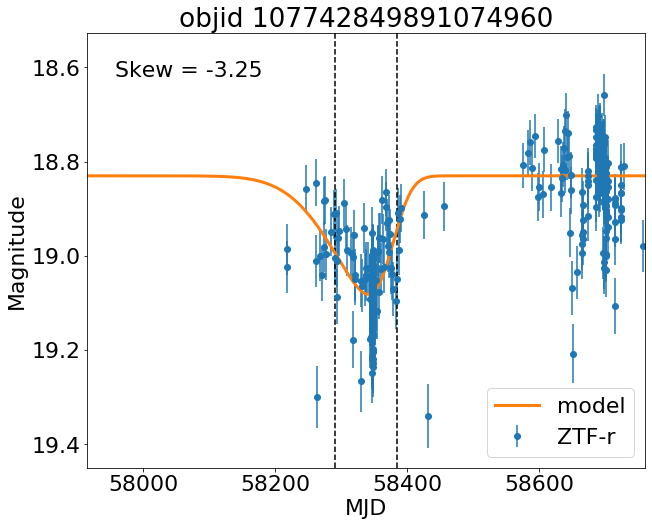

16.257125854492188


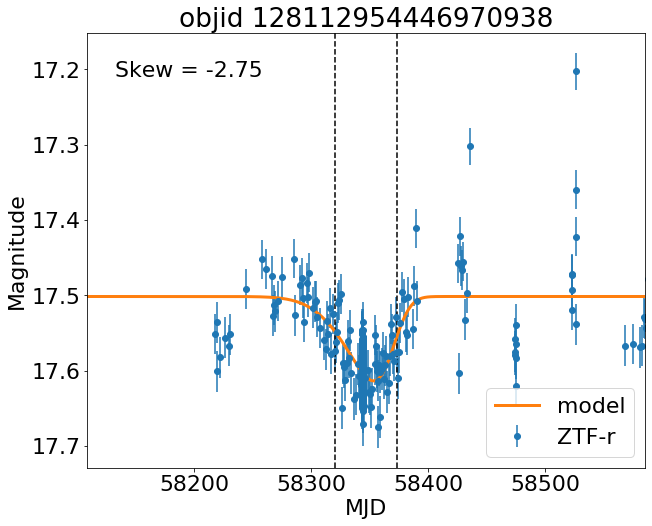

16.148595809936523


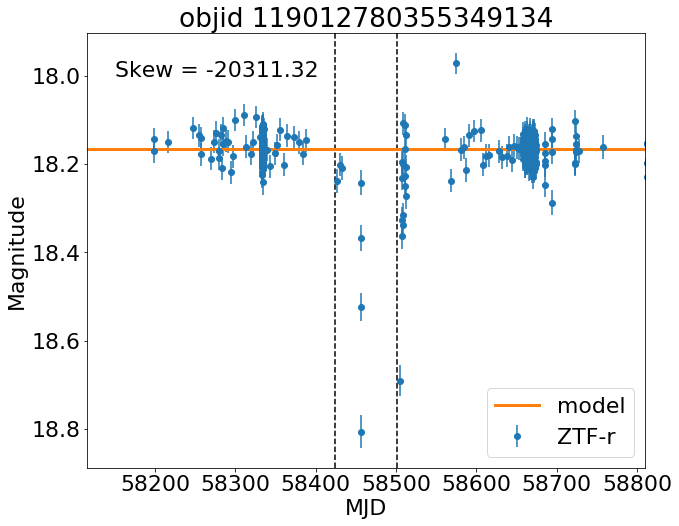

16.118515014648438


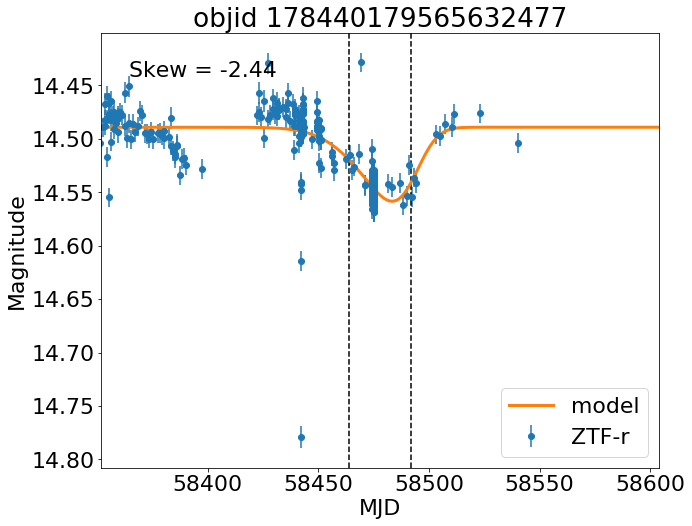

16.118515014648438


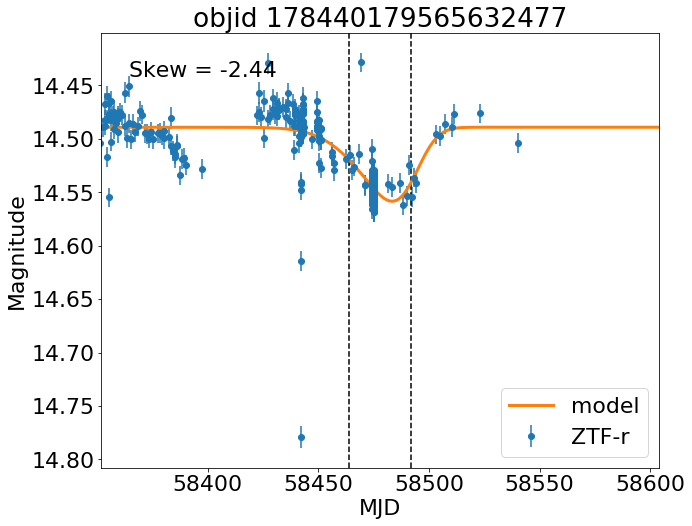

16.08588409423828


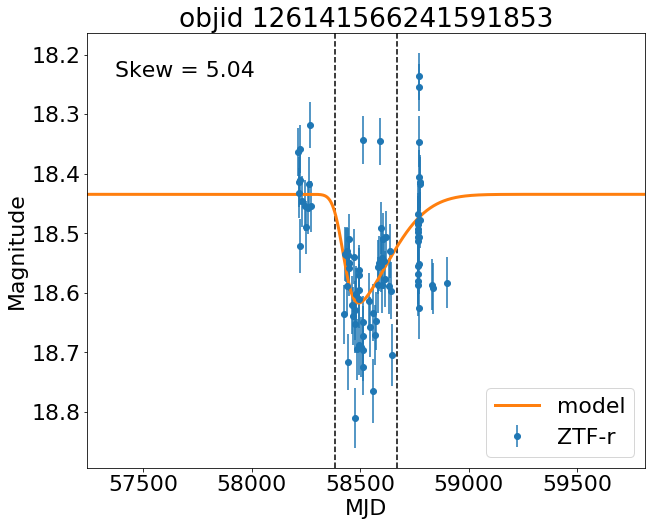

16.08588409423828


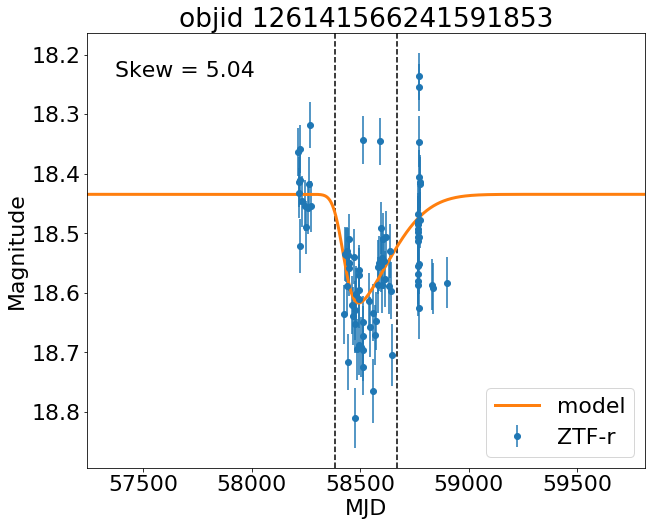

16.009801864624023


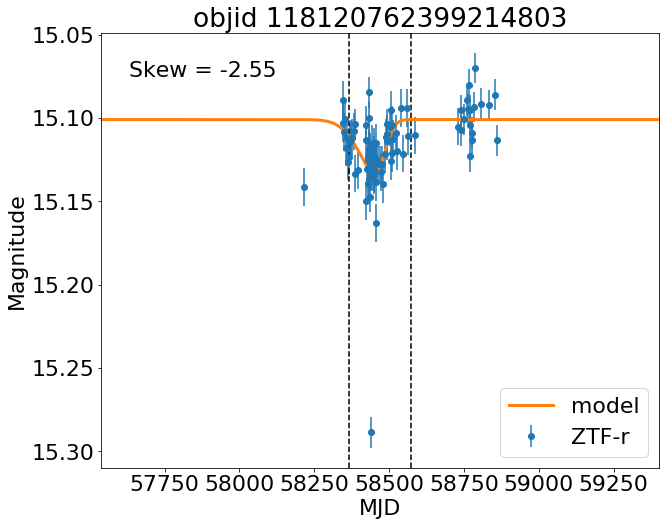

15.960809707641602


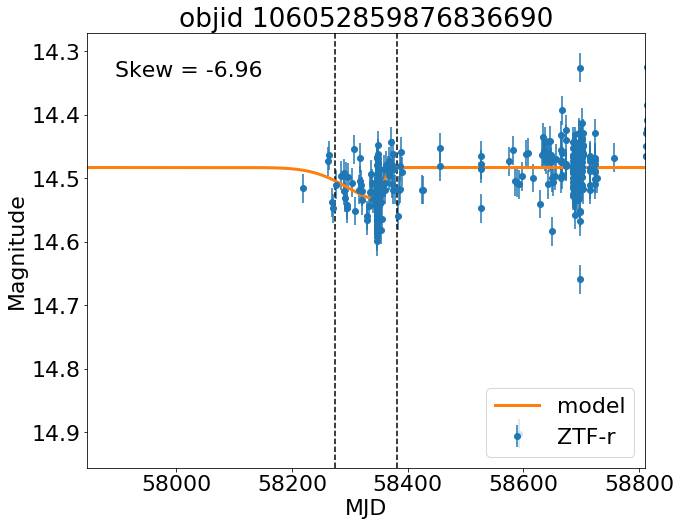

15.936223983764648


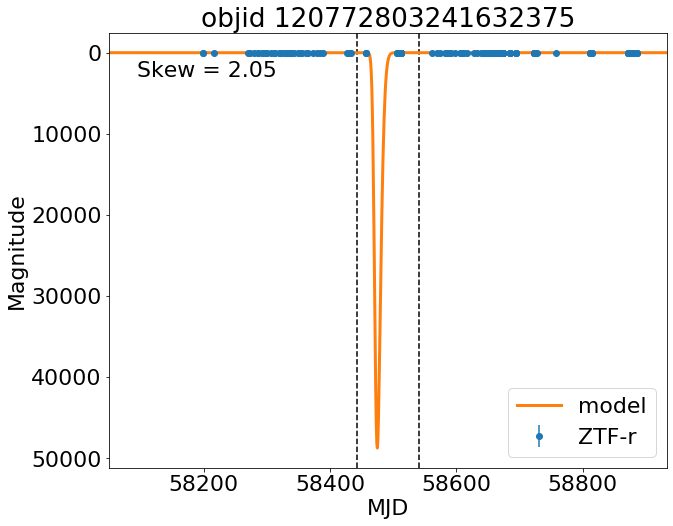

15.912896156311035


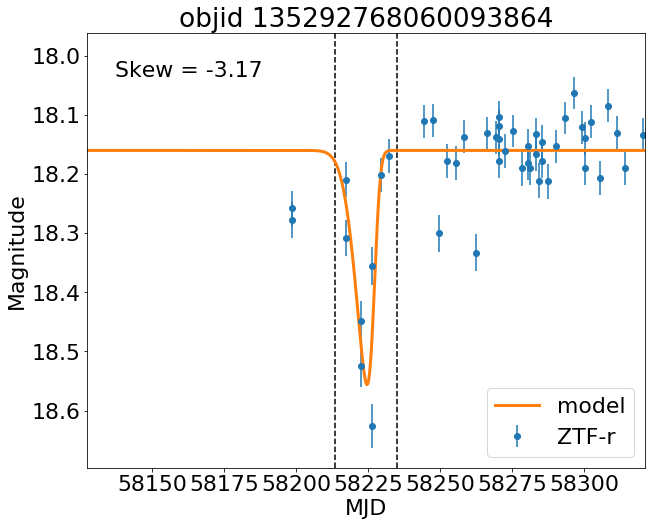

In [14]:
for i in range(100):
    plot_model(fits_to_show_in_memory[i], "r", 4.0)